## Wall Bond Pattern Check

#### General Description:
The bond or joint pattern of a masonry wall can have a significant influence on its flexural strength. The brick alignment classifier will check for the bond pattern in walls from wall images. Specifically, the classifier will distinguish between a compliant or a non-compliant wall, as defined on the basis of its proximity to a running bond or a stack bond respectively, as shown in the images below

<img src="img/alignmentcheck.png" width=300 height=300 >
<!-- <img src="wallnogo.png" width=125 height=125, img align="left" > -->

#### Threshold for compliance:
For a wall to be compliant on the basis of this check, the head joints in the successive rows of bricks should be horizontally offset by at least one quarter the unit length

#### Methodology of Check:
The current methodology setup for checking the bond pattern is as follows:
1. Process a wall image to get contours of bricks (Segmentation using trained Unet Model)
2. Process mask image to extract key features from mask image : Eg. centroid, extreme points, etc. of brick contours
3. Compute alignment of brick contours using the features as follows:
   -Group the centroids corresponding to each row of bricks (approximated by comparing the y coordinate of centroid points)
   -Calculate the difference in x coordinates of successive rows
   -Divide the difference by the average unit length of the bricks being compared
   -If the average horizontal offset for any row is less than 0.25, the image is classified as "No Go", otherwise "Go"

#### Outputs:
 - “Go” or “No Go” label for compliant and non-compliant bond pattern respectively
 - The original image with the non-compliant rows highlighted (Pending)
 - Overall score and percentage of compliant rows with respect to all the rows (Pending)

#### Constraints
For the script to correctly label the bond pattern, the input images submitted to the mobile app should meet the following requirements:
 - The input image should be cropped to show just the bricks and bond pattern
 - If more than one wall is being checked at a time, a separate photo should be taken for each wall
 - It is recommended to show no more than 13 rows of bricks in one picture 

***

#### **Step 0: Authorisation**

In [ ]:
#Step1: Authorisation Step, Click on the click, then copy and paste the auto-generated code and hit enter
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


### **Step 1: Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope

### **Step 2: Load Raw & Mask Images** 

In [ ]:
"""
UPDATE filepaths accordingly for mask image, raw image, and test image folders
"""
##FILE PATHS
mask_path  = "/content/gdrive/My Drive/Colab Notebooks/Unet Wall Check/dataset/Masks/"
image_path = "/content/gdrive/My Drive/Colab Notebooks/Unet Wall Check/dataset/Images/"
test_image_path = "/content/gdrive/My Drive/Colab Notebooks/Unet Wall Check/dataset/Test Images/"


In [ ]:
test_images = sorted([(name,test_image_path+name) for name in os.listdir(test_image_path)])

## **Step 3: Extract Features from Mask Images**

#### **Define reusable functions**

#### **Display Images**

In [ ]:
# Display one image
def display_one(a, title1 = "Raw Image", mode=None):
    plt.imshow(a,mode), plt.title(title1)
    plt.show()
    
# Display two images
def display_two(a, b, title1 = "Raw Image", title2 = "Mask Image",mode=None):
    plt.subplot(121), plt.imshow(a,mode), plt.title(title1)
#     plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b,mode), plt.title(title2)
#     plt.xticks([]), plt.yticks([])
    plt.show()
    
# Display multiple images
def display_many(images,titles,mode=None):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(2, 3, plt_idx)
        plt.title(titles[i])
        plt.imshow(img,mode)
    plt.show()


#### **Change Image Format**

In [ ]:
def convert2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def convert2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def convert2hsv(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

#### **Get Mask Image**

In [ ]:
## Read and resize raw image
def get_aspect_ratio(img):
  img = cv2.imread(img)
  w   = img.shape[1]
  h   = img.shape[0]

  ar  = w/h #aspect ratio: w/h
  return ar

def read_image(img):
    x = cv2.imread(img) 
    img_resized = cv2.resize(x, (256, 256))
    img_rgb  = convert2rgb(img_resized)
    img_norm = img_resized/255  ##normalising: also helps reduce the training time  size= 256*256*3
    return [img_resized,img_rgb,img_norm]


# ## Read and resize mask image
# def read_mask(img):
#     x = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
#     # img = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(x, (256, 256))
#     img = np.expand_dims(img, axis=-1) ##Add dimension to its last axis as it's grayscale image: from 256*256 to 256*256*1
#     return img


## Join the ground truth and the predicted mask
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

### FUNCTION TO GET MASK IMAGE
def get_mask(img): # img =normalised image,
    
    with CustomObjectScope({'iou': iou}):
        model = tf.keras.models.load_model("/content/gdrive/My Drive/Colab Notebooks/Unet Wall Check/files/model.h5") ###UPDATE PATH TO UNET MODEL

        # x = read_image(img) #raw image
        y_pred = model.predict(np.expand_dims(img, axis=0))[0] > 0.5
        mask_image = mask_parse(y_pred)*255
        mask_image = mask_image.astype(np.uint8) #convert from float64 to uint8
        # mask_image = y_pred*255.0
        

        return mask_image,mask_parse(y_pred)



#### **Extract Features from Mask**

In [ ]:
def get_key_features(raw_image,mask_image):

  #FEATURES TO EXTRACT
  feature_list = []
  df_features  = pd.DataFrame(columns = [ 'area','cX','cY','centroid','extLeft','extRight','extTop','extBot',"contour height","contour width",'M[m00]'])
  

  ## EXTRACT CONTOURS FROM GRAY IMAGE
  mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(mask_image,127,255,0)
  contours,hierarchy = cv2.findContours(thresh, 1, 2)


  #Create blank images for showing contours 
  blank_image1 = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8) #For contours included
  blank_image2 = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8) #For contours excluded
 

  areas = [] #list of areas of contours
  total_contours = len(contours)
  print("Total Contours Found: ",total_contours)

  ## Approximate minimum threshold for one contour/ brick
  fraction = mask_image.shape[0:2][0]/20  ##Need to do additional test with different factors but worked so far

  for cnt in contours:
    area = cv2.contourArea(cnt) 

    if area >= fraction**2: #minimum threshold for contour area (to exclude small contours not representing bricks)

      ## APPROACH 1: CONTOUR APPROXIMATION
      epsilon = 0.001*cv2.arcLength(cnt, True)
      approx = cv2.approxPolyDP(cnt, epsilon, True) #approximated contour

      # determine the most extreme points along the contour
      extLeft = tuple(approx[approx[:, :, 0].argmin()][0])
      extRight = tuple(approx[approx[:, :, 0].argmax()][0])
      extTop = tuple(approx[approx[:, :, 1].argmin()][0])
      extBot = tuple(approx[approx[:, :, 1].argmax()][0])
      
      contourheight = abs(extTop[1]-extBot[1]) #approximate contour height
      contourwidth  = abs(extLeft[0]-extRight[0]) #approximate contour width

      # calculate moments for each contour
      M = cv2.moments(approx)

      # calculate x,y coordinate of centroid
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      centroid = (cX,cY)
      # [extLeft, extRight, extTop, extBot]

      #Extract useful contour features
      contour_features = {'cX':cX,'cY':cY,'centroid':(cX,cY),"extLeft":(extLeft),"extRight":(extRight),"extTop":(extTop),"extBot":(extBot),
                          "contour height":contourheight,"contour width":contourwidth,'area':area, 'M["m00"]':M["m00"]} #collect all relevant features
      feature_list.append(contour_features) #add features to list

      df_features = df_features.append(contour_features, ignore_index=True)

      ## Draw contours and points in blank image for visualization

      tpl = tuple([random.randint(0, 255) for _ in range(3)]) #assign random color
      cv2.fillPoly(blank_image1, [approx], tpl) #fill contour with random color
      # cv2.drawContours(blank_image2, [approx], 0, tpl, 1) #draw contour with random color   
      cv2.circle(blank_image1, extLeft, 3, (0, 0, 255), -1)
      cv2.circle(blank_image1, extRight, 3, (0, 255, 0), -1)
      cv2.circle(blank_image1, extTop, 3, (255, 0, 0), -1)
      cv2.circle(blank_image1, extBot, 3, (255, 255, 0), -1)
      cv2.circle(blank_image1, centroid, 3, (255, 255, 255), -1)

    ## Checking the contours that have been excluded
    elif area < fraction**2:

      ## APPROACH 1: CONTOUR APPROXIMATION
      epsilon = 0.001*cv2.arcLength(cnt, True)
      approx = cv2.approxPolyDP(cnt, epsilon, True) #approximated contour

      # determine the most extreme points along the contour
      extLeft = tuple(approx[approx[:, :, 0].argmin()][0])
      extRight = tuple(approx[approx[:, :, 0].argmax()][0])
      extTop = tuple(approx[approx[:, :, 1].argmin()][0])
      extBot = tuple(approx[approx[:, :, 1].argmax()][0])
      
      contourheight = abs(extTop[1]-extBot[1]) #approximate contour height
      contourwidth  = abs(extLeft[0]-extRight[0]) #approximate contour width
      
      tpl = tuple([random.randint(0, 255) for _ in range(3)]) #assign random color
      cv2.fillPoly(blank_image2, [approx], tpl) #fill contour with random color
      # cv2.drawContours(blank_image2, [approx], 0, tpl, 1) #draw contour with random color     

  display_one(blank_image1,"Image Features") #Display the included contours
  display_one(blank_image2,"Excluded Contours") #Display the exclude contours
  # display(df_features)

  return df_features

  # feature_list = [(cx,cy), (ulx,uy), (urx,ury), (lrx,lry), (llx,lly),] ##Output format



  

#### Approximate contour alignment by row

In [ ]:
### Check Alignment 
  
''' Algorithm to check alignment:

1) Sort contours by centroid heights and group contours by row assuming they represent individual bricks in each row
2) To compute the percentage of alignment of bricks, first
'''
## Compute alignment based on contour feature analysis.

def compute_alignment (df_features):

  ### Estimate n for cluster approximation
  meancontourheight = df_features['contour height'].mean()
  n = round(meancontourheight/2) 
  print("N = Mean contour height /2 :",n)

  ### Sort dataframe by centroid height to group contours by height
  df_features.sort_values(by=['cY'],ascending=True, inplace=True)

  cYs = df_features['cY'].to_numpy()

  ## Group centroids by row
  df_features['Row'] =  np.cumsum([0] + list(1*(cYs[1:] - cYs[0:-1] > n))) + 1 #Group contours by rows
  df_features.sort_values(by=['Row','cX'],ascending=True, inplace=True) #Sort again by row and cX
  df_features['outlier'] = df_features['contour width'] > df_features['contour width'].quantile(.90) #filtering out by percentile of contour width
  display(df_features)
  # df_features = df_features[df_features['contour width'] < df_features['contour width'].quantile(.90)]
  df_features   = df_features[df_features['outlier']==False]
  display(df_features)

  # df_features['contour width'].plot(kind='hist', color='r', alpha=0.5)
  # plt.show()


  df_groups  = pd.DataFrame(df_features.groupby(['Row'],as_index=False).agg({'cX': list, 'contour width':list,'cY':list,'extLeft':list,'extRight':list,'extTop':list,'extBot':list})) #add row as a separate col
  print("No. of rows: ", df_groups['cX'].count())

  df_groups['count'] = df_groups['cX'].apply(lambda row: len(row))
  

  ## Get consecutive rows of centroids
  df_combined = pd.DataFrame()
  df_combined['cxs_combined'] = df_groups['cX'] + df_groups['cX'].shift(1)
  df_combined['count'] = df_groups['count']+df_groups['count'].shift(1)
  df_combined['contour width'] = df_groups['contour width']+df_groups['contour width'].shift(1) 
  

  df_combined['Rows'] = list(zip(df_groups['Row'],df_groups['Row'].shift(1))) #zip row numbers
  
  df_combined         = df_combined.dropna() #drop nans
  df_combined['Rows'] = df_combined['Rows'].apply(lambda row: sorted(row)) ##sort row list

  df_combined['index_argsort'] = df_combined['cxs_combined'].apply(lambda row: np.argsort(np.array(row))) #argsort to sort contours and cX in similar way

  df_combined['cxs_combined']  = df_combined['cxs_combined'].apply(lambda row: np.array(row)) #convert to numpy array
  df_combined['cxs_combined']  = df_combined.apply(lambda row: row['cxs_combined'][row['index_argsort']], axis=1) #sort by argsort

  df_combined['contour width']  = df_combined['contour width'].apply(lambda row: np.array(row)) #convert to numpy array
  df_combined['contour width']  = df_combined.apply(lambda row: row['contour width'][row['index_argsort']], axis=1) # sort by argsort

  
  df_combined['difference']     = df_combined['cxs_combined'].apply(lambda row: abs(np.array(row[0:-1])-np.array(row[1:])))
  df_combined['average_length'] = df_combined['contour width'].apply(lambda row: (abs(np.array(row[0:-1])+np.array(row[1:])/2))) #average length of corresponding bricks (assuming cX1-cX2 = approx length of brick )
  df_combined['difference_normalized'] = df_combined['difference']/df_combined['average_length']

  limit = 0.245
  df_combined ['nogos']    = df_combined['difference_normalized'].apply(lambda row: np.where(row<limit))
  
  df_combined['num_nogos'] = df_combined['nogos'].apply(lambda row: len(row[0]))
  
  df_combined['nogo_percent'] = round((df_combined['num_nogos']*100*2)/df_combined['count'],2) #count/2

  df_combined['output']    = np.where(df_combined['nogo_percent']>=50,True,False)

  Nogo = df_combined['output'].any()
  

  if Nogo:
    result = "No Go"

  elif not Nogo:
    result = "Go"

  else:
    result = "Undetermined"

  # print('DF Groups:')
  # display(df_groups)
  print("DF Combined:")
  display(df_combined)
  print(Nogo)
  print("Wall Alignment Check Result: ",result)
  return df_groups

  

  

### Implement Wall Bond Pattern Check

0b8dc7ae8be23dbf9e6e8f0e11505aa4.jpg


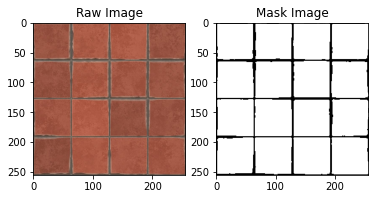

Total Contours Found:  16


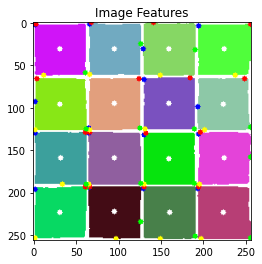

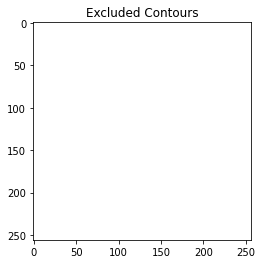

N = Mean contour height /2 : 30.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
13  3425.5   31   31    (31, 31)  ...    NaN   3425.5   1   False
15  3465.0   95   31    (95, 31)  ...    NaN   3465.0   1   False
14  3586.5  159   31   (159, 31)  ...    NaN   3586.5   1   False
12  3497.5  224   31   (224, 31)  ...    NaN   3497.5   1   False
10  3520.0   31   96    (31, 96)  ...    NaN   3520.0   2   False
9   3503.0   95   95    (95, 95)  ...    NaN   3503.0   2   False
11  3503.0  159   95   (159, 95)  ...    NaN   3503.0   2   False
8   3489.0  223   96   (223, 96)  ...    NaN   3489.0   2    True
7   3575.5   32  159   (32, 159)  ...    NaN   3575.5   3   False
6   3656.5   95  159   (95, 159)  ...    NaN   3656.5   3   False
4   3530.0  159  160  (159, 160)  ...    NaN   3530.0   3   False
5   3549.5  224  159  (224, 159)  ...    NaN   3549.5   3   False
3   3456.0   31  223   (31, 223)  ...    NaN   3456.0   4   False
2   3568.5   95  222   (95, 222)  ...    NaN   3568.5   4   False
1   3633.5  160  223  (160, 223)  ...    NaN   3633.5   4   False
0   3621.0  223  223  (223, 223)  ...    NaN   3621.0   4    True

[16 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
13  3425.5   31   31    (31, 31)  ...    NaN   3425.5   1   False
15  3465.0   95   31    (95, 31)  ...    NaN   3465.0   1   False
14  3586.5  159   31   (159, 31)  ...    NaN   3586.5   1   False
12  3497.5  224   31   (224, 31)  ...    NaN   3497.5   1   False
10  3520.0   31   96    (31, 96)  ...    NaN   3520.0   2   False
9   3503.0   95   95    (95, 95)  ...    NaN   3503.0   2   False
11  3503.0  159   95   (159, 95)  ...    NaN   3503.0   2   False
7   3575.5   32  159   (32, 159)  ...    NaN   3575.5   3   False
6   3656.5   95  159   (95, 159)  ...    NaN   3656.5   3   False
4   3530.0  159  160  (159, 160)  ...    NaN   3530.0   3   False
5   3549.5  224  159  (224, 159)  ...    NaN   3549.5   3   False
3   3456.0   31  223   (31, 223)  ...    NaN   3456.0   4   False
2   3568.5   95  222   (95, 222)  ...    NaN   3568.5   4   False
1   3633.5  160  223  (160, 223)  ...    NaN   3633.5   4   False

[14 rows x 14 columns]

No. of rows:  4
DF Combined:


cxs_combined  count  ... nogo_percent output
1  [31, 31, 95, 95, 159, 159, 224]    7.0  ...        85.71   True
2  [31, 32, 95, 95, 159, 159, 224]    7.0  ...        85.71   True
3  [31, 32, 95, 95, 159, 160, 224]    7.0  ...        85.71   True

[3 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row                  cX  ... count    Mortar Thickness Vertical
0    1  [31, 95, 159, 224]  ...     4   [[5, 57], [3, 6], [4, 28]]
1    2       [31, 95, 159]  ...     3            [[3, 1], [5, 57]]
2    3  [32, 95, 159, 224]  ...     4  [[3, 60], [4, 57], [5, 58]]
3    4       [31, 95, 160]  ...     3            [[3, 0], [3, 39]]

[4 rows x 10 columns]

11.png


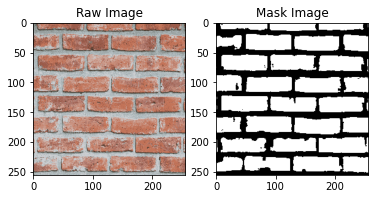

Total Contours Found:  46


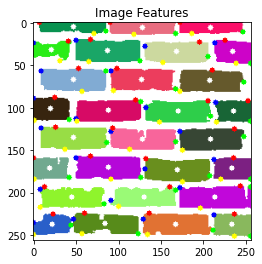

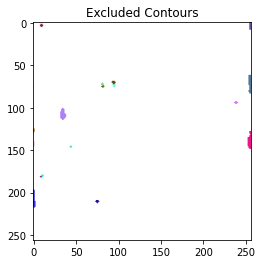

N = Mean contour height /2 : 12.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
27   850.0   47    5     (47, 5)  ...    NaN    850.0   1    True
26  1008.0  128    6    (128, 6)  ...    NaN   1008.0   1   False
25   885.5  208    6    (208, 6)  ...    NaN    885.5   1   False
22   662.5   21   32    (21, 32)  ...    NaN    662.5   2   False
24  1818.0   87   33    (87, 33)  ...    NaN   1818.0   2   False
21  1670.5  168   34   (168, 34)  ...    NaN   1670.5   2   False
23  1023.0  234   34   (234, 34)  ...    NaN   1023.0   2   False
20  1825.5   47   67    (47, 67)  ...    NaN   1825.5   3   False
19  1703.5  127   67   (127, 67)  ...    NaN   1703.5   3   False
18  1691.5  207   68   (207, 68)  ...    NaN   1691.5   3   False
17  1052.5   20  101   (20, 101)  ...    NaN   1052.5   4   False
16  1750.5   88  103   (88, 103)  ...    NaN   1750.5   4   False
15  1720.5  170  104  (170, 104)  ...    NaN   1720.5   4   False
14   920.5  235  104  (235, 104)  ...    NaN    920.5   4   False
13  1834.5   47  135   (47, 135)  ...    NaN   1834.5   5   False
12  1657.0  128  137  (128, 137)  ...    NaN   1657.0   5   False
11  1736.0  208  137  (208, 137)  ...    NaN   1736.0   5   False
9    927.5   19  171   (19, 171)  ...    NaN    927.5   6   False
10  1848.0   88  170   (88, 170)  ...    NaN   1848.0   6   False
7   1826.5  169  173  (169, 173)  ...    NaN   1826.5   6   False
8   1015.5  233  171  (233, 171)  ...    NaN   1015.5   6   False
5   1511.0   45  205   (45, 205)  ...    NaN   1511.0   7   False
4   1445.5  130  205  (130, 205)  ...    NaN   1445.5   7   False
6   1928.0  213  205  (213, 205)  ...    NaN   1928.0   7    True
1    835.5   22  237   (22, 237)  ...    NaN    835.5   8   False
3   1507.5   84  236   (84, 236)  ...    NaN   1507.5   8   False
2   1768.5  167  237  (167, 237)  ...    NaN   1768.5   8    True
0   1022.0  233  237  (233, 237)  ...    NaN   1022.0   8   False

[28 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
26  1008.0  128    6    (128, 6)  ...    NaN   1008.0   1   False
25   885.5  208    6    (208, 6)  ...    NaN    885.5   1   False
22   662.5   21   32    (21, 32)  ...    NaN    662.5   2   False
24  1818.0   87   33    (87, 33)  ...    NaN   1818.0   2   False
21  1670.5  168   34   (168, 34)  ...    NaN   1670.5   2   False
23  1023.0  234   34   (234, 34)  ...    NaN   1023.0   2   False
20  1825.5   47   67    (47, 67)  ...    NaN   1825.5   3   False
19  1703.5  127   67   (127, 67)  ...    NaN   1703.5   3   False
18  1691.5  207   68   (207, 68)  ...    NaN   1691.5   3   False
17  1052.5   20  101   (20, 101)  ...    NaN   1052.5   4   False
16  1750.5   88  103   (88, 103)  ...    NaN   1750.5   4   False
15  1720.5  170  104  (170, 104)  ...    NaN   1720.5   4   False
14   920.5  235  104  (235, 104)  ...    NaN    920.5   4   False
13  1834.5   47  135   (47, 135)  ...    NaN   1834.5   5   False
12  1657.0  128  137  (128, 137)  ...    NaN   1657.0   5   False
11  1736.0  208  137  (208, 137)  ...    NaN   1736.0   5   False
9    927.5   19  171   (19, 171)  ...    NaN    927.5   6   False
10  1848.0   88  170   (88, 170)  ...    NaN   1848.0   6   False
7   1826.5  169  173  (169, 173)  ...    NaN   1826.5   6   False
8   1015.5  233  171  (233, 171)  ...    NaN   1015.5   6   False
5   1511.0   45  205   (45, 205)  ...    NaN   1511.0   7   False
4   1445.5  130  205  (130, 205)  ...    NaN   1445.5   7   False
1    835.5   22  237   (22, 237)  ...    NaN    835.5   8   False
3   1507.5   84  236   (84, 236)  ...    NaN   1507.5   8   False
0   1022.0  233  237  (233, 237)  ...    NaN   1022.0   8   False

[25 rows x 14 columns]

No. of rows:  8
DF Combined:


cxs_combined  count  ... nogo_percent output
1      [21, 87, 128, 168, 208, 234]    6.0  ...          0.0  False
2  [21, 47, 87, 127, 168, 207, 234]    7.0  ...          0.0  False
3  [20, 47, 88, 127, 170, 207, 235]    7.0  ...          0.0  False
4  [20, 47, 88, 128, 170, 208, 235]    7.0  ...          0.0  False
5  [19, 47, 88, 128, 169, 208, 233]    7.0  ...          0.0  False
6       [19, 45, 88, 130, 169, 233]    6.0  ...          0.0  False
7            [22, 45, 84, 130, 233]    5.0  ...          0.0  False

[7 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row                  cX  ... count    Mortar Thickness Vertical
0    1          [128, 208]  ...     2                    [[5, 13]]
1    2  [21, 87, 168, 234]  ...     4   [[8, 2], [6, 17], [8, 16]]
2    3      [47, 127, 207]  ...     3             [[6, 0], [5, 3]]
3    4  [20, 88, 170, 235]  ...     4    [[8, 1], [6, 7], [6, 16]]
4    5      [47, 128, 208]  ...     3           [[5, 13], [5, 12]]
5    6  [19, 88, 169, 233]  ...     4  [[8, 23], [5, 10], [5, 19]]
6    7           [45, 130]  ...     2                     [[8, 4]]
7    8       [22, 84, 233]  ...     3           [[3, 7], [89, 22]]

[8 rows x 10 columns]

40.png


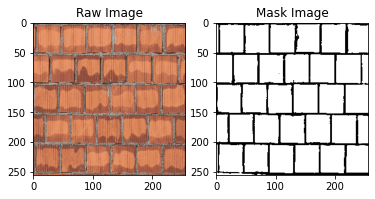

Total Contours Found:  45


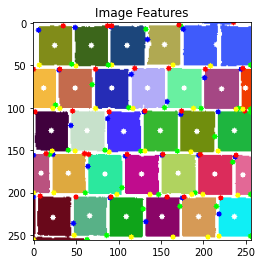

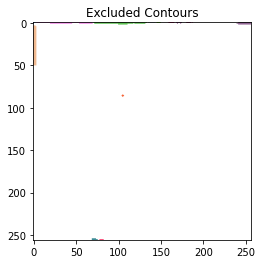

N = Mean contour height /2 : 23.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
28  1719.5   25   27    (25, 27)  ...    NaN   1719.5   1   False
27  1721.5   68   27    (68, 27)  ...    NaN   1721.5   1   False
26  1783.5  110   27   (110, 27)  ...    NaN   1783.5   1    True
29  1620.5  154   26   (154, 26)  ...    NaN   1620.5   1   False
30  3385.0  215   26   (215, 26)  ...    NaN   3385.0   1    True
22  1169.5   12   77    (12, 77)  ...    NaN   1169.5   2   False
21  1706.5   49   77    (49, 77)  ...    NaN   1706.5   2   False
20  1730.0   92   77    (92, 77)  ...    NaN   1730.0   2   False
25  1739.0  134   77   (134, 77)  ...    NaN   1739.0   2   False
24  1781.5  177   77   (177, 77)  ...    NaN   1781.5   2   False
19  1833.0  221   78   (221, 78)  ...    NaN   1833.0   2   False
23   486.5  249   77   (249, 77)  ...    NaN    486.5   2   False
14  1691.5   21  127   (21, 127)  ...    NaN   1691.5   3   False
18  1764.5   63  127   (63, 127)  ...    NaN   1764.5   3   False
13  1756.0  106  128  (106, 128)  ...    NaN   1756.0   3   False
17  1800.5  149  127  (149, 127)  ...    NaN   1800.5   3   False
16  1854.0  192  128  (192, 128)  ...    NaN   1854.0   3   False
15  1752.0  236  127  (236, 127)  ...    NaN   1752.0   3   False
12   822.0    9  177    (9, 177)  ...    NaN    822.0   4   False
11  1690.5   41  177   (41, 177)  ...    NaN   1690.5   4   False
10  1760.0   84  178   (84, 178)  ...    NaN   1760.0   4   False
9   1730.5  127  178  (127, 178)  ...    NaN   1730.5   4   False
8   1768.0  170  177  (170, 177)  ...    NaN   1768.0   4   False
7   1795.5  213  178  (213, 178)  ...    NaN   1795.5   4   False
6    780.0  246  179  (246, 179)  ...    NaN    780.0   4   False
5   1892.5   23  229   (23, 229)  ...    NaN   1892.5   5    True
4   1671.5   66  227   (66, 227)  ...    NaN   1671.5   5   False
3   1719.5  109  228  (109, 228)  ...    NaN   1719.5   5   False
2   1735.0  151  228  (151, 228)  ...    NaN   1735.0   5   False
1   1737.5  194  228  (194, 228)  ...    NaN   1737.5   5   False
0   1633.5  236  228  (236, 228)  ...    NaN   1633.5   5   False

[31 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
28  1719.5   25   27    (25, 27)  ...    NaN   1719.5   1   False
27  1721.5   68   27    (68, 27)  ...    NaN   1721.5   1   False
29  1620.5  154   26   (154, 26)  ...    NaN   1620.5   1   False
22  1169.5   12   77    (12, 77)  ...    NaN   1169.5   2   False
21  1706.5   49   77    (49, 77)  ...    NaN   1706.5   2   False
20  1730.0   92   77    (92, 77)  ...    NaN   1730.0   2   False
25  1739.0  134   77   (134, 77)  ...    NaN   1739.0   2   False
24  1781.5  177   77   (177, 77)  ...    NaN   1781.5   2   False
19  1833.0  221   78   (221, 78)  ...    NaN   1833.0   2   False
23   486.5  249   77   (249, 77)  ...    NaN    486.5   2   False
14  1691.5   21  127   (21, 127)  ...    NaN   1691.5   3   False
18  1764.5   63  127   (63, 127)  ...    NaN   1764.5   3   False
13  1756.0  106  128  (106, 128)  ...    NaN   1756.0   3   False
17  1800.5  149  127  (149, 127)  ...    NaN   1800.5   3   False
16  1854.0  192  128  (192, 128)  ...    NaN   1854.0   3   False
15  1752.0  236  127  (236, 127)  ...    NaN   1752.0   3   False
12   822.0    9  177    (9, 177)  ...    NaN    822.0   4   False
11  1690.5   41  177   (41, 177)  ...    NaN   1690.5   4   False
10  1760.0   84  178   (84, 178)  ...    NaN   1760.0   4   False
9   1730.5  127  178  (127, 178)  ...    NaN   1730.5   4   False
8   1768.0  170  177  (170, 177)  ...    NaN   1768.0   4   False
7   1795.5  213  178  (213, 178)  ...    NaN   1795.5   4   False
6    780.0  246  179  (246, 179)  ...    NaN    780.0   4   False
4   1671.5   66  227   (66, 227)  ...    NaN   1671.5   5   False
3   1719.5  109  228  (109, 228)  ...    NaN   1719.5   5   False
2   1735.0  151  228  (151, 228)  ...    NaN   1735.0   5   False
1   1737.5  194  228  (194, 228)  ...    NaN   1737.5   5   False
0   1633.5  236  228  (236, 228)  ...    NaN   1633.5   5   False

[28 rows x 14 columns]

No. of rows:  5
DF Combined:


cxs_combined  ...  output
1      [12, 25, 49, 68, 92, 134, 154, 177, 221, 249]  ...   False
2  [12, 21, 49, 63, 92, 106, 134, 149, 177, 192, ...  ...   False
3  [9, 21, 41, 63, 84, 106, 127, 149, 170, 192, 2...  ...   False
4  [9, 41, 66, 84, 109, 127, 151, 170, 194, 213, ...  ...   False

[4 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row  ...                          Mortar Thickness Vertical
0    1  ...                                [[4, 43], [46, 30]]
1    2  ...  [[4, 41], [4, 18], [3, 39], [3, 7], [4, 36], [...
2    3  ...      [[3, 29], [3, 37], [4, 46], [4, 43], [4, 29]]
3    4  ...  [[4, 0], [3, 31], [4, 37], [4, 46], [4, 44], [...
4    5  ...                [[4, 44], [3, 15], [3, 10], [3, 9]]

[5 rows x 10 columns]

5.png


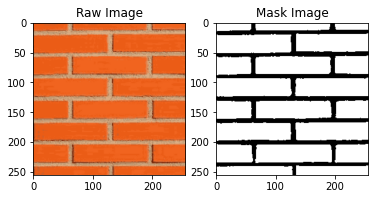

Total Contours Found:  20


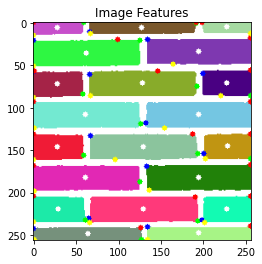

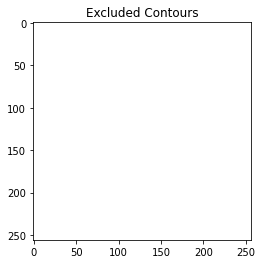

N = Mean contour height /2 : 13.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
19   777.5   28    6     (28, 6)  ...    NaN    777.5   1   False
18  1588.5  127    6    (127, 6)  ...    NaN   1588.5   1   False
17   669.0  227    5    (227, 5)  ...    NaN    669.0   1   False
15  3658.5   62   36    (62, 36)  ...    NaN   3658.5   2   False
16  3438.0  194   34   (194, 34)  ...    NaN   3438.0   2   False
13  1626.5   28   72    (28, 72)  ...    NaN   1626.5   3   False
12  3514.0  128   71   (128, 71)  ...    NaN   3514.0   3   False
14  1604.0  227   71   (227, 71)  ...    NaN   1604.0   3   False
11  3626.5   61  108   (61, 108)  ...    NaN   3626.5   4   False
10  3533.5  194  108  (194, 108)  ...    NaN   3533.5   4   False
9   1636.5   28  146   (28, 146)  ...    NaN   1636.5   5   False
8   3488.0  129  146  (129, 146)  ...    NaN   3488.0   5   False
7   1531.5  228  145  (228, 145)  ...    NaN   1531.5   5   False
5   3439.5   61  182   (61, 182)  ...    NaN   3439.5   6   False
6   3464.5  194  182  (194, 182)  ...    NaN   3464.5   6   False
4   1715.5   29  219   (29, 219)  ...    NaN   1715.5   7   False
2   3610.0  129  219  (129, 219)  ...    NaN   3610.0   7    True
3   1602.0  227  219  (227, 219)  ...    NaN   1602.0   7   False
0   1738.5   64  248   (64, 248)  ...    NaN   1738.5   8    True
1   1703.5  194  247  (194, 247)  ...    NaN   1703.5   8   False

[20 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
19   777.5   28    6     (28, 6)  ...    NaN    777.5   1   False
18  1588.5  127    6    (127, 6)  ...    NaN   1588.5   1   False
17   669.0  227    5    (227, 5)  ...    NaN    669.0   1   False
15  3658.5   62   36    (62, 36)  ...    NaN   3658.5   2   False
16  3438.0  194   34   (194, 34)  ...    NaN   3438.0   2   False
13  1626.5   28   72    (28, 72)  ...    NaN   1626.5   3   False
12  3514.0  128   71   (128, 71)  ...    NaN   3514.0   3   False
14  1604.0  227   71   (227, 71)  ...    NaN   1604.0   3   False
11  3626.5   61  108   (61, 108)  ...    NaN   3626.5   4   False
10  3533.5  194  108  (194, 108)  ...    NaN   3533.5   4   False
9   1636.5   28  146   (28, 146)  ...    NaN   1636.5   5   False
8   3488.0  129  146  (129, 146)  ...    NaN   3488.0   5   False
7   1531.5  228  145  (228, 145)  ...    NaN   1531.5   5   False
5   3439.5   61  182   (61, 182)  ...    NaN   3439.5   6   False
6   3464.5  194  182  (194, 182)  ...    NaN   3464.5   6   False
4   1715.5   29  219   (29, 219)  ...    NaN   1715.5   7   False
3   1602.0  227  219  (227, 219)  ...    NaN   1602.0   7   False
1   1703.5  194  247  (194, 247)  ...    NaN   1703.5   8   False

[18 rows x 14 columns]

No. of rows:  8
DF Combined:


cxs_combined  count  ... nogo_percent output
1  [28, 62, 127, 194, 227]    5.0  ...        40.00  False
2  [28, 62, 128, 194, 227]    5.0  ...        40.00  False
3  [28, 61, 128, 194, 227]    5.0  ...        40.00  False
4  [28, 61, 129, 194, 228]    5.0  ...        40.00  False
5  [28, 61, 129, 194, 228]    5.0  ...        40.00  False
6       [29, 61, 194, 227]    4.0  ...        50.00   True
7           [29, 194, 227]    3.0  ...        66.67   True

[7 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row              cX  ... count Mortar Thickness Vertical
0    1  [28, 127, 227]  ...     3         [[7, 11], [7, 1]]
1    2       [62, 194]  ...     2                  [[9, 1]]
2    3  [28, 128, 227]  ...     3        [[8, 23], [7, 15]]
3    4       [61, 194]  ...     2                  [[6, 1]]
4    5  [28, 129, 228]  ...     3         [[8, 23], [7, 0]]
5    6       [61, 194]  ...     2                 [[8, 18]]
6    7       [29, 227]  ...     2                [[137, 0]]
7    8           [194]  ...     1                        []

[8 rows x 10 columns]

9.png


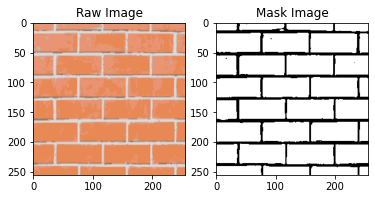

Total Contours Found:  38


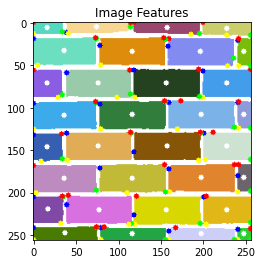

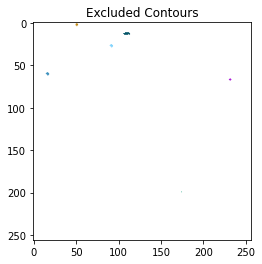

N = Mean contour height /2 : 14.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
31   439.5   16    6     (16, 6)  ...    NaN    439.5   1   False
30   852.5   74    5     (74, 5)  ...    NaN    852.5   1   False
29   967.5  157    6    (157, 6)  ...    NaN    967.5   1   False
28   802.0  227    7    (227, 7)  ...    NaN    802.0   1   False
27  2223.0   36   33    (36, 33)  ...    NaN   2223.0   2   False
26  2307.0  116   34   (116, 34)  ...    NaN   2307.0   2   False
25  2371.5  196   34   (196, 34)  ...    NaN   2371.5   2   False
24   457.0  247   34   (247, 34)  ...    NaN    457.0   2   False
21  1028.5   16   71    (16, 71)  ...    NaN   1028.5   3   False
20  2321.5   76   71    (76, 71)  ...    NaN   2321.5   3   False
23  2416.0  156   71   (156, 71)  ...    NaN   2416.0   3   False
22  1729.0  227   71   (227, 71)  ...    NaN   1729.0   3   False
17  2243.0   36  109   (36, 109)  ...    NaN   2243.0   4   False
19  2426.0  116  108  (116, 108)  ...    NaN   2426.0   4   False
18  2389.5  197  108  (197, 108)  ...    NaN   2389.5   4   False
16   456.0  247  108  (247, 108)  ...    NaN    456.0   4   False
12  1021.5   16  146   (16, 146)  ...    NaN   1021.5   5   False
15  2344.5   76  145   (76, 145)  ...    NaN   2344.5   5   False
14  2401.5  157  145  (157, 145)  ...    NaN   2401.5   5    True
13  1712.5  227  145  (227, 145)  ...    NaN   1712.5   5   False
8   2272.0   36  183   (36, 183)  ...    NaN   2272.0   6   False
11  2387.5  116  183  (116, 183)  ...    NaN   2387.5   6   False
10  2338.0  197  182  (197, 182)  ...    NaN   2338.0   6   False
9    454.0  247  182  (247, 182)  ...    NaN    454.0   6   False
6   1039.5   17  219   (17, 219)  ...    NaN   1039.5   7   False
7   2316.5   77  220   (77, 220)  ...    NaN   2316.5   7   False
5   2438.5  156  220  (156, 220)  ...    NaN   2438.5   7    True
4   1681.5  227  220  (227, 220)  ...    NaN   1681.5   7   False
3   1065.0   37  247   (37, 247)  ...    NaN   1065.0   8   False
2   1001.5  116  248  (116, 248)  ...    NaN   1001.5   8   False
1    990.5  197  248  (197, 248)  ...    NaN    990.5   8   False
0    194.5  247  248  (247, 248)  ...    NaN    194.5   8   False

[32 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
31   439.5   16    6     (16, 6)  ...    NaN    439.5   1   False
30   852.5   74    5     (74, 5)  ...    NaN    852.5   1   False
29   967.5  157    6    (157, 6)  ...    NaN    967.5   1   False
28   802.0  227    7    (227, 7)  ...    NaN    802.0   1   False
27  2223.0   36   33    (36, 33)  ...    NaN   2223.0   2   False
26  2307.0  116   34   (116, 34)  ...    NaN   2307.0   2   False
25  2371.5  196   34   (196, 34)  ...    NaN   2371.5   2   False
24   457.0  247   34   (247, 34)  ...    NaN    457.0   2   False
21  1028.5   16   71    (16, 71)  ...    NaN   1028.5   3   False
20  2321.5   76   71    (76, 71)  ...    NaN   2321.5   3   False
23  2416.0  156   71   (156, 71)  ...    NaN   2416.0   3   False
22  1729.0  227   71   (227, 71)  ...    NaN   1729.0   3   False
17  2243.0   36  109   (36, 109)  ...    NaN   2243.0   4   False
19  2426.0  116  108  (116, 108)  ...    NaN   2426.0   4   False
18  2389.5  197  108  (197, 108)  ...    NaN   2389.5   4   False
16   456.0  247  108  (247, 108)  ...    NaN    456.0   4   False
12  1021.5   16  146   (16, 146)  ...    NaN   1021.5   5   False
15  2344.5   76  145   (76, 145)  ...    NaN   2344.5   5   False
13  1712.5  227  145  (227, 145)  ...    NaN   1712.5   5   False
8   2272.0   36  183   (36, 183)  ...    NaN   2272.0   6   False
11  2387.5  116  183  (116, 183)  ...    NaN   2387.5   6   False
10  2338.0  197  182  (197, 182)  ...    NaN   2338.0   6   False
9    454.0  247  182  (247, 182)  ...    NaN    454.0   6   False
6   1039.5   17  219   (17, 219)  ...    NaN   1039.5   7   False
7   2316.5   77  220   (77, 220)  ...    NaN   2316.5   7   False
4   1681.5  227  220  (227, 220)  ...    NaN   1681.5   7   False
3   1065.0   37  247   (37, 247)  ...    NaN   1065.0   8   False
2   1001.5  116  248  (116, 248)  ...    NaN   1001.5   8   False
1    990.5  197  248  (197, 248)  ...    NaN    990.5   8   False
0    194.5  247  248  (247, 248)  ...    NaN    194.5   8   False

[30 rows x 14 columns]

No. of rows:  8
DF Combined:


cxs_combined  count  ... nogo_percent output
1  [16, 36, 74, 116, 157, 196, 227, 247]    8.0  ...          0.0  False
2  [16, 36, 76, 116, 156, 196, 227, 247]    8.0  ...          0.0  False
3  [16, 36, 76, 116, 156, 197, 227, 247]    8.0  ...          0.0  False
4       [16, 36, 76, 116, 197, 227, 247]    7.0  ...          0.0  False
5       [16, 36, 76, 116, 197, 227, 247]    7.0  ...          0.0  False
6       [17, 36, 77, 116, 197, 227, 247]    7.0  ...          0.0  False
7       [17, 37, 77, 116, 197, 227, 247]    7.0  ...          0.0  False

[7 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row                   cX  ... count    Mortar Thickness Vertical
0    1   [16, 74, 157, 227]  ...     4    [[5, 1], [4, 5], [4, 13]]
1    2  [36, 116, 196, 247]  ...     4    [[4, 8], [3, 8], [5, 21]]
2    3   [16, 76, 156, 227]  ...     4  [[5, 26], [4, 28], [4, 30]]
3    4  [36, 116, 197, 247]  ...     4    [[4, 2], [4, 1], [4, 29]]
4    5        [16, 76, 227]  ...     3           [[5, 30], [85, 0]]
5    6  [36, 116, 197, 247]  ...     4  [[4, 26], [4, 27], [4, 13]]
6    7        [17, 77, 227]  ...     3           [[4, 9], [85, 31]]
7    8  [37, 116, 197, 247]  ...     4   [[4, 0], [4, 10], [4, 12]]

[8 rows x 10 columns]

Annotation 2020-05-28 120758.png


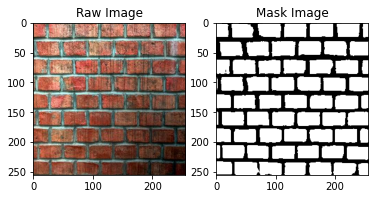

Total Contours Found:  62


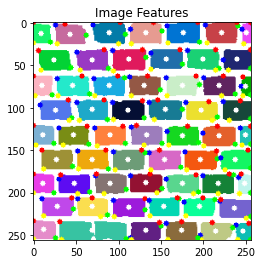

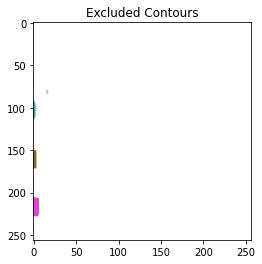

N = Mean contour height /2 : 11.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
57   423.0    9   13     (9, 13)  ...    NaN    423.0   1   False
51   740.5   43   14    (43, 14)  ...    NaN    740.5   1   False
56   819.5   89   12    (89, 12)  ...    NaN    819.5   1   False
55   845.5  132   12   (132, 12)  ...    NaN    845.5   1   False
54   876.0  176   12   (176, 12)  ...    NaN    876.0   1   False
53   840.5  221   12   (221, 12)  ...    NaN    840.5   1   False
52   210.0  250   12   (250, 12)  ...    NaN    210.0   1   False
45   799.0   24   44    (24, 44)  ...    NaN    799.0   2   False
50   790.5   69   44    (69, 44)  ...    NaN    790.5   2   False
49   874.5  112   43   (112, 43)  ...    NaN    874.5   2    True
48   797.5  156   43   (156, 43)  ...    NaN    797.5   2   False
47   802.5  199   43   (199, 43)  ...    NaN    802.5   2   False
46   690.0  239   43   (239, 43)  ...    NaN    690.0   2   False
44   487.5   10   74    (10, 74)  ...    NaN    487.5   3   False
43   823.5   46   74    (46, 74)  ...    NaN    823.5   3   False
42   752.5   89   74    (89, 74)  ...    NaN    752.5   3   False
41   753.0  130   74   (130, 74)  ...    NaN    753.0   3   False
40   795.5  175   74   (175, 74)  ...    NaN    795.5   3    True
39   783.0  218   74   (218, 74)  ...    NaN    783.0   3   False
38   222.5  249   75   (249, 75)  ...    NaN    222.5   3   False
37   771.5   26  103   (26, 103)  ...    NaN    771.5   4   False
36   761.5   69  102   (69, 102)  ...    NaN    761.5   4   False
34   782.0  111  103  (111, 103)  ...    NaN    782.0   4   False
35   822.5  155  102  (155, 102)  ...    NaN    822.5   4    True
32   750.0  197  103  (197, 103)  ...    NaN    750.0   4   False
33   705.0  238  103  (238, 103)  ...    NaN    705.0   4   False
31   515.0   11  132   (11, 132)  ...    NaN    515.0   5   False
29   716.0   47  132   (47, 132)  ...    NaN    716.0   5   False
28   749.0   90  132   (90, 132)  ...    NaN    749.0   5   False
30   750.5  133  132  (133, 132)  ...    NaN    750.5   5   False
27   770.0  175  133  (175, 133)  ...    NaN    770.0   5   False
26   824.5  218  133  (218, 133)  ...    NaN    824.5   5   False
25   254.5  249  132  (249, 132)  ...    NaN    254.5   5   False
24   773.5   27  161   (27, 161)  ...    NaN    773.5   6   False
23   768.5   69  161   (69, 161)  ...    NaN    768.5   6   False
22   804.5  111  161  (111, 161)  ...    NaN    804.5   6   False
21   791.0  154  161  (154, 161)  ...    NaN    791.0   6   False
19   798.5  196  161  (196, 161)  ...    NaN    798.5   6   False
20   738.5  237  161  (237, 161)  ...    NaN    738.5   6   False
18   509.5   11  189   (11, 189)  ...    NaN    509.5   7   False
13   740.5   48  189   (48, 189)  ...    NaN    740.5   7   False
17   778.0   90  189   (90, 189)  ...    NaN    778.0   7   False
16   745.0  132  188  (132, 188)  ...    NaN    745.0   7   False
12   745.0  175  189  (175, 189)  ...    NaN    745.0   7   False
15   766.5  217  189  (217, 189)  ...    NaN    766.5   7   False
14   302.5  248  189  (248, 189)  ...    NaN    302.5   7   False
11   744.0   28  216   (28, 216)  ...    NaN    744.0   8   False
10   712.0   69  216   (69, 216)  ...    NaN    712.0   8   False
7    756.0  112  217  (112, 217)  ...    NaN    756.0   8   False
9    695.0  153  216  (153, 216)  ...    NaN    695.0   8   False
8    699.0  195  216  (195, 216)  ...    NaN    699.0   8   False
6    737.5  236  218  (236, 218)  ...    NaN    737.5   8   False
5    528.0   12  243   (12, 243)  ...    NaN    528.0   9   False
4   1497.0   69  244   (69, 244)  ...    NaN   1497.0   9    True
2    677.5  132  244  (132, 244)  ...    NaN    677.5   9   False
3    718.0  174  244  (174, 244)  ...    NaN    718.0   9   False
1    679.5  214  245  (214, 245)  ...    NaN    679.5   9   False
0    306.5  246  245  (246, 245)  ...    NaN    306.5   9   False

[58 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
57  423.0    9   13     (9, 13)  ...    NaN    423.0   1   False
51  740.5   43   14    (43, 14)  ...    NaN    740.5   1   False
56  819.5   89   12    (89, 12)  ...    NaN    819.5   1   False
55  845.5  132   12   (132, 12)  ...    NaN    845.5   1   False
54  876.0  176   12   (176, 12)  ...    NaN    876.0   1   False
53  840.5  221   12   (221, 12)  ...    NaN    840.5   1   False
52  210.0  250   12   (250, 12)  ...    NaN    210.0   1   False
45  799.0   24   44    (24, 44)  ...    NaN    799.0   2   False
50  790.5   69   44    (69, 44)  ...    NaN    790.5   2   False
48  797.5  156   43   (156, 43)  ...    NaN    797.5   2   False
47  802.5  199   43   (199, 43)  ...    NaN    802.5   2   False
46  690.0  239   43   (239, 43)  ...    NaN    690.0   2   False
44  487.5   10   74    (10, 74)  ...    NaN    487.5   3   False
43  823.5   46   74    (46, 74)  ...    NaN    823.5   3   False
42  752.5   89   74    (89, 74)  ...    NaN    752.5   3   False
41  753.0  130   74   (130, 74)  ...    NaN    753.0   3   False
39  783.0  218   74   (218, 74)  ...    NaN    783.0   3   False
38  222.5  249   75   (249, 75)  ...    NaN    222.5   3   False
37  771.5   26  103   (26, 103)  ...    NaN    771.5   4   False
36  761.5   69  102   (69, 102)  ...    NaN    761.5   4   False
34  782.0  111  103  (111, 103)  ...    NaN    782.0   4   False
32  750.0  197  103  (197, 103)  ...    NaN    750.0   4   False
33  705.0  238  103  (238, 103)  ...    NaN    705.0   4   False
31  515.0   11  132   (11, 132)  ...    NaN    515.0   5   False
29  716.0   47  132   (47, 132)  ...    NaN    716.0   5   False
28  749.0   90  132   (90, 132)  ...    NaN    749.0   5   False
30  750.5  133  132  (133, 132)  ...    NaN    750.5   5   False
27  770.0  175  133  (175, 133)  ...    NaN    770.0   5   False
26  824.5  218  133  (218, 133)  ...    NaN    824.5   5   False
25  254.5  249  132  (249, 132)  ...    NaN    254.5   5   False
24  773.5   27  161   (27, 161)  ...    NaN    773.5   6   False
23  768.5   69  161   (69, 161)  ...    NaN    768.5   6   False
22  804.5  111  161  (111, 161)  ...    NaN    804.5   6   False
21  791.0  154  161  (154, 161)  ...    NaN    791.0   6   False
19  798.5  196  161  (196, 161)  ...    NaN    798.5   6   False
20  738.5  237  161  (237, 161)  ...    NaN    738.5   6   False
18  509.5   11  189   (11, 189)  ...    NaN    509.5   7   False
13  740.5   48  189   (48, 189)  ...    NaN    740.5   7   False
17  778.0   90  189   (90, 189)  ...    NaN    778.0   7   False
16  745.0  132  188  (132, 188)  ...    NaN    745.0   7   False
12  745.0  175  189  (175, 189)  ...    NaN    745.0   7   False
15  766.5  217  189  (217, 189)  ...    NaN    766.5   7   False
14  302.5  248  189  (248, 189)  ...    NaN    302.5   7   False
11  744.0   28  216   (28, 216)  ...    NaN    744.0   8   False
10  712.0   69  216   (69, 216)  ...    NaN    712.0   8   False
7   756.0  112  217  (112, 217)  ...    NaN    756.0   8   False
9   695.0  153  216  (153, 216)  ...    NaN    695.0   8   False
8   699.0  195  216  (195, 216)  ...    NaN    699.0   8   False
6   737.5  236  218  (236, 218)  ...    NaN    737.5   8   False
5   528.0   12  243   (12, 243)  ...    NaN    528.0   9   False
2   677.5  132  244  (132, 244)  ...    NaN    677.5   9   False
3   718.0  174  244  (174, 244)  ...    NaN    718.0   9   False
1   679.5  214  245  (214, 245)  ...    NaN    679.5   9   False
0   306.5  246  245  (246, 245)  ...    NaN    306.5   9   False

[54 rows x 14 columns]

No. of rows:  9
DF Combined:


cxs_combined  ...  output
1  [9, 24, 43, 69, 89, 132, 156, 176, 199, 221, 2...  ...   False
2  [10, 24, 46, 69, 89, 130, 156, 199, 218, 239, ...  ...   False
3  [10, 26, 46, 69, 89, 111, 130, 197, 218, 238, ...  ...   False
4  [11, 26, 47, 69, 90, 111, 133, 175, 197, 218, ...  ...   False
5  [11, 27, 47, 69, 90, 111, 133, 154, 175, 196, ...  ...   False
6  [11, 27, 48, 69, 90, 111, 132, 154, 175, 196, ...  ...   False
7  [11, 28, 48, 69, 90, 112, 132, 153, 175, 195, ...  ...   False
8  [12, 28, 69, 112, 132, 153, 174, 195, 214, 236...  ...   False

[8 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row  ...                          Mortar Thickness Vertical
0    1  ...  [[6, 20], [8, 12], [6, 6], [6, 6], [7, 20], [5...
1    2  ...              [[7, 18], [50, 18], [6, 16], [5, 10]]
2    3  ...       [[6, 19], [5, 18], [6, 1], [51, 14], [7, 9]]
3    4  ...              [[6, 18], [6, 20], [49, 18], [7, 18]]
4    5  ...  [[6, 18], [7, 19], [7, 19], [6, 14], [5, 11], ...
5    6  ...        [[6, 18], [6, 20], [5, 0], [5, 18], [4, 1]]
6    7  ...  [[6, 16], [7, 19], [5, 16], [5, 11], [5, 19], ...
7    8  ...        [[5, 12], [7, 17], [5, 11], [6, 4], [6, 2]]
8    9  ...                  [[88, 0], [6, 3], [3, 3], [4, 3]]

[9 rows x 10 columns]

Annotation 2020-05-28 121159.png


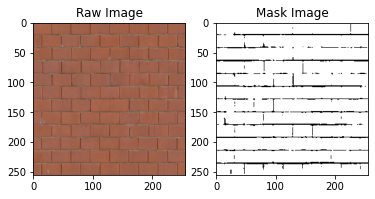

Total Contours Found:  71


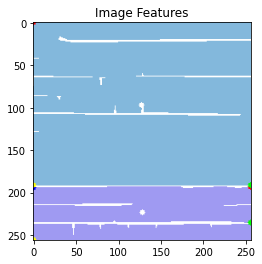

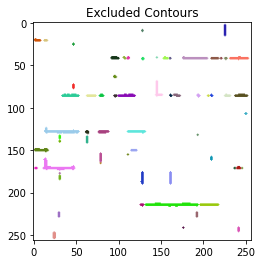

N = Mean contour height /2 : 22.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
5    237.5   51   41    (51, 41)  ...    NaN    237.5   1   False
6  46170.5  127   97   (127, 97)  ...    NaN  46369.0   2   False
3    270.5   78  145   (78, 145)  ...    NaN    270.5   3   False
1    558.0  142  170  (142, 170)  ...    NaN    558.0   3   False
2    347.0  190  149  (190, 149)  ...    NaN    347.0   3   False
4    280.0  194  128  (194, 128)  ...    NaN    280.0   3   False
0  14233.0  128  223  (128, 223)  ...    NaN  14191.5   4   False

[7 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
5    237.5   51   41    (51, 41)  ...    NaN    237.5   1   False
6  46170.5  127   97   (127, 97)  ...    NaN  46369.0   2   False
3    270.5   78  145   (78, 145)  ...    NaN    270.5   3   False
1    558.0  142  170  (142, 170)  ...    NaN    558.0   3   False
2    347.0  190  149  (190, 149)  ...    NaN    347.0   3   False
4    280.0  194  128  (194, 128)  ...    NaN    280.0   3   False
0  14233.0  128  223  (128, 223)  ...    NaN  14191.5   4   False

[7 rows x 14 columns]

No. of rows:  4
DF Combined:


cxs_combined  count  ... nogo_percent output
1                 [51, 127]    2.0  ...          0.0  False
2  [78, 127, 142, 190, 194]    5.0  ...        160.0   True
3  [78, 128, 142, 190, 194]    5.0  ...        160.0   True

[3 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row                   cX  ... count         Mortar Thickness Vertical
0    1                 [51]  ...     1                                []
1    2                [127]  ...     1                                []
2    3  [78, 142, 190, 194]  ...     4  [[64, 21], [105, 21], [121, 22]]
3    4                [128]  ...     1                                []

[4 rows x 10 columns]

Annotation 2020-05-28 121159_cropped1.png


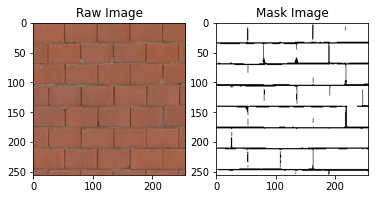

Total Contours Found:  23


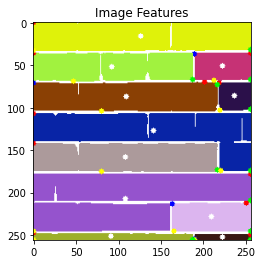

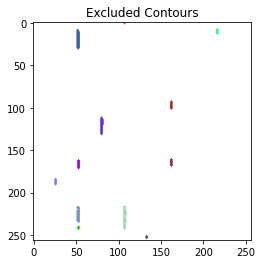

N = Mean contour height /2 : 17.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
10   8230.5  126   16   (126, 16)  ...    NaN   8234.0   1   False
9    5707.0   92   52    (92, 52)  ...    NaN   5707.5   2   False
8    2022.5  222   51   (222, 51)  ...    NaN   2022.5   2   False
7    6909.5  109   87   (109, 87)  ...    NaN   6910.0   3   False
6    1171.0  236   86   (236, 86)  ...    NaN   1171.0   3   False
5    9135.0  141  127  (141, 127)  ...    NaN   9136.0   4   False
4    6855.5  108  158  (108, 158)  ...    NaN   6855.5   5   False
3   13011.0  108  207  (108, 207)  ...    NaN  12920.0   6   False
2    2992.5  209  228  (209, 228)  ...    NaN   2992.5   7   False
1    1258.0   91  251   (91, 251)  ...    NaN   1258.0   8   False
0     390.5  222  252  (222, 252)  ...    NaN    390.5   8   False

[11 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
10   8230.5  126   16   (126, 16)  ...    NaN   8234.0   1   False
9    5707.0   92   52    (92, 52)  ...    NaN   5707.5   2   False
8    2022.5  222   51   (222, 51)  ...    NaN   2022.5   2   False
7    6909.5  109   87   (109, 87)  ...    NaN   6910.0   3   False
6    1171.0  236   86   (236, 86)  ...    NaN   1171.0   3   False
5    9135.0  141  127  (141, 127)  ...    NaN   9136.0   4   False
4    6855.5  108  158  (108, 158)  ...    NaN   6855.5   5   False
3   13011.0  108  207  (108, 207)  ...    NaN  12920.0   6   False
2    2992.5  209  228  (209, 228)  ...    NaN   2992.5   7   False
1    1258.0   91  251   (91, 251)  ...    NaN   1258.0   8   False
0     390.5  222  252  (222, 252)  ...    NaN    390.5   8   False

[11 rows x 14 columns]

No. of rows:  8
DF Combined:


cxs_combined  count  ... nogo_percent output
1       [92, 126, 222]    3.0  ...        66.67   True
2  [92, 109, 222, 236]    4.0  ...       100.00   True
3      [109, 141, 236]    3.0  ...        66.67   True
4           [108, 141]    2.0  ...       100.00   True
5           [108, 108]    2.0  ...       100.00   True
6           [108, 209]    2.0  ...         0.00  False
7       [91, 209, 222]    3.0  ...        66.67   True

[7 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row          cX  ... count Mortar Thickness Vertical
0    1       [126]  ...     1                        []
1    2   [92, 222]  ...     2                 [[2, 30]]
2    3  [109, 236]  ...     2                  [[2, 2]]
3    4       [141]  ...     1                        []
4    5       [108]  ...     1                        []
5    6       [108]  ...     1                        []
6    7       [209]  ...     1                        []
7    8   [91, 222]  ...     2                  [[2, 1]]

[8 rows x 10 columns]

Annotation 2020-05-28 121159_cropped2.png


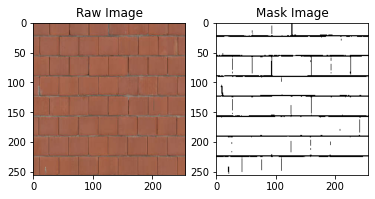

Total Contours Found:  37


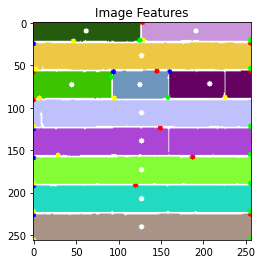

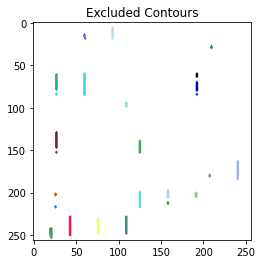

N = Mean contour height /2 : 15.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
10  2663.0   62   10    (62, 10)  ...    NaN   2663.0   1   False
9   2644.5  191   10   (191, 10)  ...    NaN   2644.5   1   False
8   7514.5  127   39   (127, 39)  ...    NaN   7515.0   2   False
5   2736.0   45   73    (45, 73)  ...    NaN   2736.0   3   False
7   1992.5  125   73   (125, 73)  ...    NaN   1992.5   3   False
6   2798.0  207   72   (207, 72)  ...    NaN   2798.0   3   False
4   7508.5  127  106  (127, 106)  ...    NaN   7507.0   4   False
3   7645.0  127  139  (127, 139)  ...    NaN   7648.5   5   False
2   7705.0  127  173  (127, 173)  ...    NaN   7706.5   6   False
1   7631.5  127  207  (127, 207)  ...    NaN   7633.0   7   False
0   7461.5  127  240  (127, 240)  ...    NaN   7460.5   8   False

[11 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
10  2663.0   62   10    (62, 10)  ...    NaN   2663.0   1   False
9   2644.5  191   10   (191, 10)  ...    NaN   2644.5   1   False
8   7514.5  127   39   (127, 39)  ...    NaN   7515.0   2   False
5   2736.0   45   73    (45, 73)  ...    NaN   2736.0   3   False
7   1992.5  125   73   (125, 73)  ...    NaN   1992.5   3   False
6   2798.0  207   72   (207, 72)  ...    NaN   2798.0   3   False
4   7508.5  127  106  (127, 106)  ...    NaN   7507.0   4   False
3   7645.0  127  139  (127, 139)  ...    NaN   7648.5   5   False
2   7705.0  127  173  (127, 173)  ...    NaN   7706.5   6   False
1   7631.5  127  207  (127, 207)  ...    NaN   7633.0   7   False
0   7461.5  127  240  (127, 240)  ...    NaN   7460.5   8   False

[11 rows x 14 columns]

No. of rows:  8
DF Combined:


cxs_combined  count  ... nogo_percent output
1       [62, 127, 191]    3.0  ...        66.67   True
2  [45, 125, 127, 207]    4.0  ...        50.00   True
3  [45, 125, 127, 207]    4.0  ...        50.00   True
4           [127, 127]    2.0  ...       100.00   True
5           [127, 127]    2.0  ...       100.00   True
6           [127, 127]    2.0  ...       100.00   True
7           [127, 127]    2.0  ...       100.00   True

[7 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row              cX  ... count Mortar Thickness Vertical
0    1       [62, 191]  ...     2                 [[3, 21]]
1    2           [127]  ...     1                        []
2    3  [45, 125, 207]  ...     3         [[2, 6], [2, 30]]
3    4           [127]  ...     1                        []
4    5           [127]  ...     1                        []
5    6           [127]  ...     1                        []
6    7           [127]  ...     1                        []
7    8           [127]  ...     1                        []

[8 rows x 10 columns]

Annotation 2020-05-28 135954.png


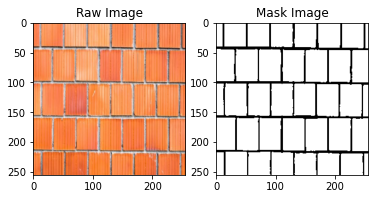

Total Contours Found:  38


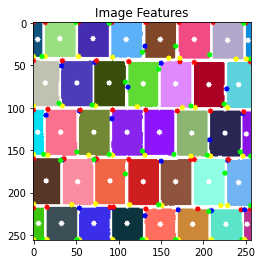

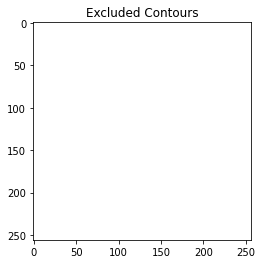

N = Mean contour height /2 : 24.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
37   400.0    5   20     (5, 20)  ...    NaN    400.0   1   False
36  1400.5   31   19    (31, 19)  ...    NaN   1400.5   1   False
35  1401.5   70   19    (70, 19)  ...    NaN   1401.5   1   False
34  1434.0  109   20   (109, 20)  ...    NaN   1434.0   1   False
33  1437.5  149   20   (149, 20)  ...    NaN   1437.5   1   False
32  1501.0  189   20   (189, 20)  ...    NaN   1501.0   1   False
31  1479.5  228   21   (228, 21)  ...    NaN   1479.5   1   False
30   215.0  252   21   (252, 21)  ...    NaN    215.0   1   False
29  1547.5   14   71    (14, 71)  ...    NaN   1547.5   2   False
28  1858.0   51   71    (51, 71)  ...    NaN   1858.0   2   False
27  1840.5   89   71    (89, 71)  ...    NaN   1840.5   2   False
26  1769.0  129   72   (129, 72)  ...    NaN   1769.0   2   False
25  1840.0  167   72   (167, 72)  ...    NaN   1840.0   2   False
23  1810.0  206   73   (206, 73)  ...    NaN   1810.0   2   False
24  1439.0  241   73   (241, 73)  ...    NaN   1439.0   2   False
21   601.0    5  129    (5, 129)  ...    NaN    601.0   3   False
22  1847.5   32  129   (32, 129)  ...    NaN   1847.5   3   False
20  1835.5   71  129   (71, 129)  ...    NaN   1835.5   3   False
19  1840.0  110  129  (110, 129)  ...    NaN   1840.0   3   False
18  1775.5  148  129  (148, 129)  ...    NaN   1775.5   3   False
17  1833.0  186  130  (186, 130)  ...    NaN   1833.0   3   False
16  1852.0  225  130  (225, 130)  ...    NaN   1852.0   3   False
15   466.5  250  131  (250, 131)  ...    NaN    466.5   3   False
14  1645.0   15  186   (15, 186)  ...    NaN   1645.0   4   False
13  1849.5   52  187   (52, 187)  ...    NaN   1849.5   4   False
12  1779.5   90  186   (90, 186)  ...    NaN   1779.5   4   False
11  1853.0  129  187  (129, 187)  ...    NaN   1853.0   4   False
10  1841.0  167  187  (167, 187)  ...    NaN   1841.0   4   False
9   1865.5  206  187  (206, 187)  ...    NaN   1865.5   4   False
8   1447.5  241  188  (241, 188)  ...    NaN   1447.5   4   False
4    444.0    6  236    (6, 236)  ...    NaN    444.0   5   False
7   1329.5   33  236   (33, 236)  ...    NaN   1329.5   5   False
6   1326.5   71  236   (71, 236)  ...    NaN   1326.5   5   False
5   1290.5  110  236  (110, 236)  ...    NaN   1290.5   5   False
3   1232.5  149  237  (149, 237)  ...    NaN   1232.5   5   False
2   1247.0  187  237  (187, 237)  ...    NaN   1247.0   5   False
0   1247.0  226  237  (226, 237)  ...    NaN   1247.0   5   False
1    245.5  251  237  (251, 237)  ...    NaN    245.5   5   False

[38 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
37   400.0    5   20     (5, 20)  ...    NaN    400.0   1   False
36  1400.5   31   19    (31, 19)  ...    NaN   1400.5   1   False
35  1401.5   70   19    (70, 19)  ...    NaN   1401.5   1   False
34  1434.0  109   20   (109, 20)  ...    NaN   1434.0   1   False
33  1437.5  149   20   (149, 20)  ...    NaN   1437.5   1   False
32  1501.0  189   20   (189, 20)  ...    NaN   1501.0   1   False
31  1479.5  228   21   (228, 21)  ...    NaN   1479.5   1   False
30   215.0  252   21   (252, 21)  ...    NaN    215.0   1   False
29  1547.5   14   71    (14, 71)  ...    NaN   1547.5   2   False
28  1858.0   51   71    (51, 71)  ...    NaN   1858.0   2   False
27  1840.5   89   71    (89, 71)  ...    NaN   1840.5   2   False
26  1769.0  129   72   (129, 72)  ...    NaN   1769.0   2   False
25  1840.0  167   72   (167, 72)  ...    NaN   1840.0   2   False
23  1810.0  206   73   (206, 73)  ...    NaN   1810.0   2   False
24  1439.0  241   73   (241, 73)  ...    NaN   1439.0   2   False
21   601.0    5  129    (5, 129)  ...    NaN    601.0   3   False
22  1847.5   32  129   (32, 129)  ...    NaN   1847.5   3   False
20  1835.5   71  129   (71, 129)  ...    NaN   1835.5   3   False
19  1840.0  110  129  (110, 129)  ...    NaN   1840.0   3   False
18  1775.5  148  129  (148, 129)  ...    NaN   1775.5   3   False
17  1833.0  186  130  (186, 130)  ...    NaN   1833.0   3   False
16  1852.0  225  130  (225, 130)  ...    NaN   1852.0   3   False
15   466.5  250  131  (250, 131)  ...    NaN    466.5   3   False
14  1645.0   15  186   (15, 186)  ...    NaN   1645.0   4   False
13  1849.5   52  187   (52, 187)  ...    NaN   1849.5   4   False
12  1779.5   90  186   (90, 186)  ...    NaN   1779.5   4   False
11  1853.0  129  187  (129, 187)  ...    NaN   1853.0   4   False
10  1841.0  167  187  (167, 187)  ...    NaN   1841.0   4   False
9   1865.5  206  187  (206, 187)  ...    NaN   1865.5   4   False
8   1447.5  241  188  (241, 188)  ...    NaN   1447.5   4   False
4    444.0    6  236    (6, 236)  ...    NaN    444.0   5   False
7   1329.5   33  236   (33, 236)  ...    NaN   1329.5   5   False
6   1326.5   71  236   (71, 236)  ...    NaN   1326.5   5   False
5   1290.5  110  236  (110, 236)  ...    NaN   1290.5   5   False
3   1232.5  149  237  (149, 237)  ...    NaN   1232.5   5   False
2   1247.0  187  237  (187, 237)  ...    NaN   1247.0   5   False
0   1247.0  226  237  (226, 237)  ...    NaN   1247.0   5   False
1    245.5  251  237  (251, 237)  ...    NaN    245.5   5   False

[38 rows x 14 columns]

No. of rows:  5
DF Combined:


cxs_combined  ...  output
1  [5, 14, 31, 51, 70, 89, 109, 129, 149, 167, 18...  ...   False
2  [5, 14, 32, 51, 71, 89, 110, 129, 148, 167, 18...  ...   False
3  [5, 15, 32, 52, 71, 90, 110, 129, 148, 167, 18...  ...   False
4  [6, 15, 33, 52, 71, 90, 110, 129, 149, 167, 18...  ...   False

[4 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row  ...                          Mortar Thickness Vertical
0    1  ...  [[4, 40], [3, 0], [3, 1], [3, 7], [4, 28], [4,...
1    2  ...  [[3, 44], [3, 50], [3, 6], [3, 7], [4, 51], [3...
2    3  ...  [[3, 46], [3, 48], [3, 42], [2, 3], [4, 51], [...
3    4  ...  [[3, 1], [2, 0], [4, 17], [3, 51], [4, 0], [3,...
4    5  ...  [[4, 38], [3, 37], [3, 1], [3, 28], [3, 35], [...

[5 rows x 10 columns]

Annotation 2020-06-09 173429.png


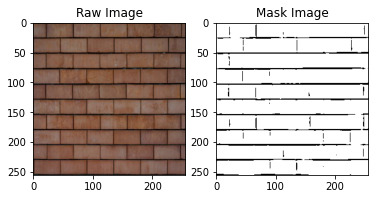

Total Contours Found:  37


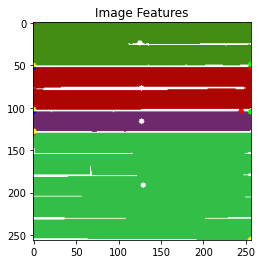

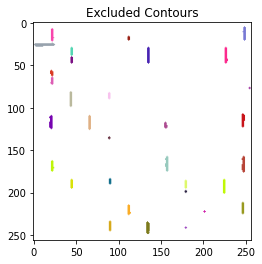

N = Mean contour height /2 : 27.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
3    289.0   72   23    (72, 23)  ...    NaN    289.0   1   False
4  12282.0  125   24   (125, 24)  ...    NaN  12340.0   1   False
2  11427.0  127   77   (127, 77)  ...    NaN  11307.0   2   False
1   5620.5  127  116  (127, 116)  ...    NaN   5620.0   3   False
0  28390.5  129  191  (129, 191)  ...    NaN  30168.5   4   False

[5 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
3    289.0   72   23    (72, 23)  ...    NaN    289.0   1   False
4  12282.0  125   24   (125, 24)  ...    NaN  12340.0   1   False
2  11427.0  127   77   (127, 77)  ...    NaN  11307.0   2   False
1   5620.5  127  116  (127, 116)  ...    NaN   5620.0   3   False
0  28390.5  129  191  (129, 191)  ...    NaN  30168.5   4   False

[5 rows x 14 columns]

No. of rows:  4
DF Combined:


cxs_combined  count   contour width  ... num_nogos nogo_percent output
1  [72, 125, 127]    3.0  [70, 255, 255]  ...         1        66.67   True
2      [127, 127]    2.0      [255, 255]  ...         1       100.00   True
3      [127, 129]    2.0      [255, 255]  ...         1       100.00   True

[3 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row         cX  ... count Mortar Thickness Vertical
0    1  [72, 125]  ...     2               [[109, 26]]
1    2      [127]  ...     1                        []
2    3      [127]  ...     1                        []
3    4      [129]  ...     1                        []

[4 rows x 10 columns]

Annotation 2020-06-09 173429_cropped.png


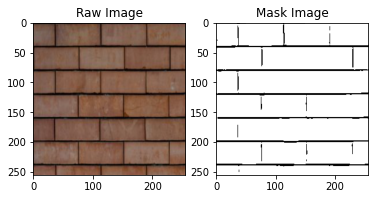

Total Contours Found:  21


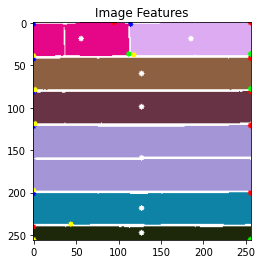

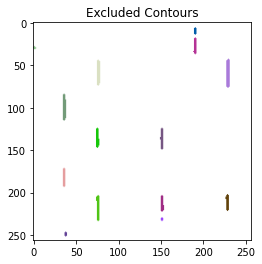

N = Mean contour height /2 : 20.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
6   4093.5   56   19    (56, 19)  ...    NaN   4093.5   1   False
5   5257.0  185   19   (185, 19)  ...    NaN   5257.0   1   False
4   9149.5  127   60   (127, 60)  ...    NaN   9150.5   2   False
3   9168.5  127   99   (127, 99)  ...    NaN   9169.0   3   False
2  18265.0  127  159  (127, 159)  ...    NaN  18035.5   4   False
1   8994.5  127  218  (127, 218)  ...    NaN   8994.5   5   False
0   3767.0  127  247  (127, 247)  ...    NaN   3768.0   6   False

[7 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
6   4093.5   56   19    (56, 19)  ...    NaN   4093.5   1   False
5   5257.0  185   19   (185, 19)  ...    NaN   5257.0   1   False
4   9149.5  127   60   (127, 60)  ...    NaN   9150.5   2   False
3   9168.5  127   99   (127, 99)  ...    NaN   9169.0   3   False
2  18265.0  127  159  (127, 159)  ...    NaN  18035.5   4   False
1   8994.5  127  218  (127, 218)  ...    NaN   8994.5   5   False
0   3767.0  127  247  (127, 247)  ...    NaN   3768.0   6   False

[7 rows x 14 columns]

No. of rows:  6
DF Combined:


cxs_combined  count    contour width  ... num_nogos nogo_percent output
1  [56, 127, 185]    3.0  [112, 255, 141]  ...         1        66.67   True
2      [127, 127]    2.0       [255, 255]  ...         1       100.00   True
3      [127, 127]    2.0       [255, 255]  ...         1       100.00   True
4      [127, 127]    2.0       [255, 255]  ...         1       100.00   True
5      [127, 127]    2.0       [255, 255]  ...         1       100.00   True

[5 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row         cX  ... count Mortar Thickness Vertical
0    1  [56, 185]  ...     2                 [[2, 35]]
1    2      [127]  ...     1                        []
2    3      [127]  ...     1                        []
3    4      [127]  ...     1                        []
4    5      [127]  ...     1                        []
5    6      [127]  ...     1                        []

[6 rows x 10 columns]

Annotation 2020-06-09 181504.png


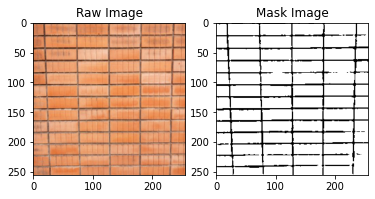

Total Contours Found:  78


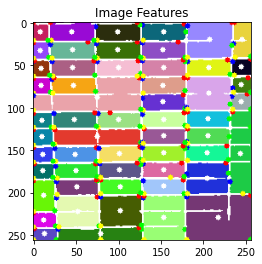

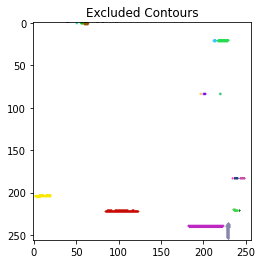

N = Mean contour height /2 : 12.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
54   308.0    8   11     (8, 11)  ...    NaN    308.0   1   False
45   312.0    8   33     (8, 33)  ...    NaN    312.0   1   False
53   994.0   45   11    (45, 11)  ...    NaN    994.0   1   False
48   912.0   46   32    (46, 32)  ...    NaN    912.0   1   False
52   925.5   99   11    (99, 11)  ...    NaN    925.5   1   False
47   917.5   99   32    (99, 32)  ...    NaN    917.5   1   False
46   883.5  152   32   (152, 32)  ...    NaN    883.5   1   False
49   909.0  153   11   (153, 11)  ...    NaN    909.0   1   False
51  1997.0  207   20   (207, 20)  ...    NaN   1997.0   1   False
50   737.0  245   20   (245, 20)  ...    NaN    737.0   1   False
41   317.5    9   54     (9, 54)  ...    NaN    317.5   2   False
40   850.0   46   53    (46, 53)  ...    NaN    850.0   2   False
39   835.0  100   53   (100, 53)  ...    NaN    835.0   2   False
43   864.0  153   53   (153, 53)  ...    NaN    864.0   2   False
42   873.0  206   53   (206, 53)  ...    NaN    873.0   2   False
44   357.0  244   52   (244, 52)  ...    NaN    357.0   2   False
33   327.0    9   74     (9, 74)  ...    NaN    327.0   3   False
38   850.0   47   74    (47, 74)  ...    NaN    850.0   3   False
37  2979.0   75   88    (75, 88)  ...    NaN   2978.5   3    True
36   855.5  152   74   (152, 74)  ...    NaN    855.5   3   False
31   832.5  152   93   (152, 93)  ...    NaN    832.5   3   False
35  1787.0  206   83   (206, 83)  ...    NaN   1787.0   3   False
34   332.5  244   73   (244, 73)  ...    NaN    332.5   3   False
32   381.0  244   93   (244, 93)  ...    NaN    381.0   3   False
25   335.5   10  115   (10, 115)  ...    NaN    335.5   4   False
28   827.0   48  114   (48, 114)  ...    NaN    827.0   4   False
27   789.0  100  114  (100, 114)  ...    NaN    789.0   4   False
26   787.5  153  114  (153, 114)  ...    NaN    787.5   4   False
30   822.5  205  113  (205, 113)  ...    NaN    822.5   4   False
22   382.0   10  134   (10, 134)  ...    NaN    382.0   5   False
21  1591.0   75  134   (75, 134)  ...    NaN   1591.0   5    True
24   774.0  153  133  (153, 133)  ...    NaN    774.0   5   False
23   823.5  205  133  (205, 133)  ...    NaN    823.5   5   False
17   349.5   11  155   (11, 155)  ...    NaN    349.5   6   False
16   762.0   49  155   (49, 155)  ...    NaN    762.0   6   False
18   773.5  101  154  (101, 154)  ...    NaN    773.5   6   False
20   779.0  153  153  (153, 153)  ...    NaN    779.0   6   False
19   805.0  204  153  (204, 153)  ...    NaN    805.0   6   False
29  1954.5  243  154  (243, 154)  ...    NaN   1954.5   6   False
12   366.0   11  174   (11, 174)  ...    NaN    366.0   7   False
7    839.5   12  203   (12, 203)  ...    NaN    839.5   7   False
11   739.0   50  174   (50, 174)  ...    NaN    739.0   7   False
10   751.5   51  193   (51, 193)  ...    NaN    751.5   7   False
15   736.0  101  173  (101, 173)  ...    NaN    736.0   7   False
9    745.5  102  193  (102, 193)  ...    NaN    745.5   7   False
14   749.0  153  173  (153, 173)  ...    NaN    749.0   7   False
8    761.5  153  192  (153, 192)  ...    NaN    761.5   7   False
13  1491.5  204  183  (204, 183)  ...    NaN   1491.5   7   False
2    406.5   12  232   (12, 232)  ...    NaN    406.5   8   False
3   1523.0   52  222   (52, 222)  ...    NaN   1523.0   8   False
5   1602.5  102  221  (102, 221)  ...    NaN   1602.5   8   False
4   2139.5  153  229  (153, 229)  ...    NaN   2139.5   8   False
6   3619.0  217  229  (217, 229)  ...    NaN   3619.0   8    True
0    324.5   13  248   (13, 248)  ...    NaN    324.5   9   False
1   1174.5   79  248   (79, 248)  ...    NaN   1174.5   9    True

[55 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
54   308.0    8   11     (8, 11)  ...    NaN    308.0   1   False
45   312.0    8   33     (8, 33)  ...    NaN    312.0   1   False
53   994.0   45   11    (45, 11)  ...    NaN    994.0   1   False
48   912.0   46   32    (46, 32)  ...    NaN    912.0   1   False
52   925.5   99   11    (99, 11)  ...    NaN    925.5   1   False
47   917.5   99   32    (99, 32)  ...    NaN    917.5   1   False
46   883.5  152   32   (152, 32)  ...    NaN    883.5   1   False
49   909.0  153   11   (153, 11)  ...    NaN    909.0   1   False
51  1997.0  207   20   (207, 20)  ...    NaN   1997.0   1   False
50   737.0  245   20   (245, 20)  ...    NaN    737.0   1   False
41   317.5    9   54     (9, 54)  ...    NaN    317.5   2   False
40   850.0   46   53    (46, 53)  ...    NaN    850.0   2   False
39   835.0  100   53   (100, 53)  ...    NaN    835.0   2   False
43   864.0  153   53   (153, 53)  ...    NaN    864.0   2   False
42   873.0  206   53   (206, 53)  ...    NaN    873.0   2   False
44   357.0  244   52   (244, 52)  ...    NaN    357.0   2   False
33   327.0    9   74     (9, 74)  ...    NaN    327.0   3   False
38   850.0   47   74    (47, 74)  ...    NaN    850.0   3   False
36   855.5  152   74   (152, 74)  ...    NaN    855.5   3   False
31   832.5  152   93   (152, 93)  ...    NaN    832.5   3   False
35  1787.0  206   83   (206, 83)  ...    NaN   1787.0   3   False
34   332.5  244   73   (244, 73)  ...    NaN    332.5   3   False
32   381.0  244   93   (244, 93)  ...    NaN    381.0   3   False
25   335.5   10  115   (10, 115)  ...    NaN    335.5   4   False
28   827.0   48  114   (48, 114)  ...    NaN    827.0   4   False
27   789.0  100  114  (100, 114)  ...    NaN    789.0   4   False
26   787.5  153  114  (153, 114)  ...    NaN    787.5   4   False
30   822.5  205  113  (205, 113)  ...    NaN    822.5   4   False
22   382.0   10  134   (10, 134)  ...    NaN    382.0   5   False
24   774.0  153  133  (153, 133)  ...    NaN    774.0   5   False
23   823.5  205  133  (205, 133)  ...    NaN    823.5   5   False
17   349.5   11  155   (11, 155)  ...    NaN    349.5   6   False
16   762.0   49  155   (49, 155)  ...    NaN    762.0   6   False
18   773.5  101  154  (101, 154)  ...    NaN    773.5   6   False
20   779.0  153  153  (153, 153)  ...    NaN    779.0   6   False
19   805.0  204  153  (204, 153)  ...    NaN    805.0   6   False
29  1954.5  243  154  (243, 154)  ...    NaN   1954.5   6   False
12   366.0   11  174   (11, 174)  ...    NaN    366.0   7   False
7    839.5   12  203   (12, 203)  ...    NaN    839.5   7   False
11   739.0   50  174   (50, 174)  ...    NaN    739.0   7   False
10   751.5   51  193   (51, 193)  ...    NaN    751.5   7   False
15   736.0  101  173  (101, 173)  ...    NaN    736.0   7   False
9    745.5  102  193  (102, 193)  ...    NaN    745.5   7   False
14   749.0  153  173  (153, 173)  ...    NaN    749.0   7   False
8    761.5  153  192  (153, 192)  ...    NaN    761.5   7   False
13  1491.5  204  183  (204, 183)  ...    NaN   1491.5   7   False
2    406.5   12  232   (12, 232)  ...    NaN    406.5   8   False
3   1523.0   52  222   (52, 222)  ...    NaN   1523.0   8   False
5   1602.5  102  221  (102, 221)  ...    NaN   1602.5   8   False
4   2139.5  153  229  (153, 229)  ...    NaN   2139.5   8   False
0    324.5   13  248   (13, 248)  ...    NaN    324.5   9   False

[51 rows x 14 columns]

No. of rows:  9
DF Combined:


cxs_combined  ...  output
1  [8, 8, 9, 45, 46, 46, 99, 99, 100, 152, 153, 1...  ...    True
2  [9, 9, 46, 47, 100, 152, 152, 153, 206, 206, 2...  ...    True
3  [9, 10, 47, 48, 100, 152, 152, 153, 205, 206, ...  ...    True
4              [10, 10, 48, 100, 153, 153, 205, 205]  ...    True
5         [10, 11, 49, 101, 153, 153, 204, 205, 243]  ...    True
6  [11, 11, 12, 49, 50, 51, 101, 101, 102, 153, 1...  ...    True
7  [11, 12, 12, 50, 51, 52, 101, 102, 102, 153, 1...  ...    True
8                             [12, 13, 52, 102, 153]  ...   False

[8 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row  ...                          Mortar Thickness Vertical
0    1  ...  [[17, 3], [2, 41], [51, 5], [1, 36], [51, 22],...
1    2  ...       [[3, 16], [3, 16], [2, 15], [3, 0], [3, 15]]
2    3  ...  [[2, 15], [55, 15], [50, 9], [2, 1], [3, 19], ...
3    4  ...               [[3, 16], [2, 15], [3, 14], [3, 16]]
4    5  ...                                 [[105, 2], [2, 1]]
5    6  ...       [[2, 15], [3, 15], [2, 14], [2, 1], [2, 26]]
6    7  ...  [[23, 4], [1, 52], [48, 6], [3, 20], [47, 18],...
7    8  ...                        [[1, 33], [2, 34], [2, 32]]
8    9  ...                                                 []

[9 rows x 10 columns]

Annotation 2020-06-09 181605.png


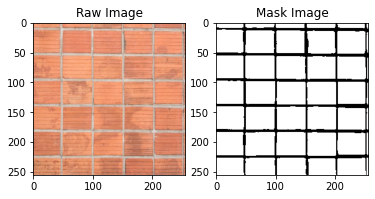

Total Contours Found:  42


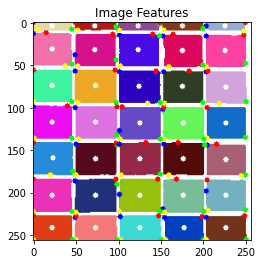

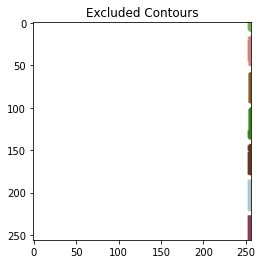

N = Mean contour height /2 : 16.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
34   399.0   22    4     (22, 4)  ...    NaN    399.0   1   False
33   402.0   72    4     (72, 4)  ...    NaN    402.0   1   False
32   425.0  123    4    (123, 4)  ...    NaN    425.0   1   False
31   422.5  175    4    (175, 4)  ...    NaN    422.5   1   False
30   399.0  225    4    (225, 4)  ...    NaN    399.0   1   False
29  1656.0   22   31    (22, 31)  ...    NaN   1656.0   2   False
28  1715.0   72   32    (72, 32)  ...    NaN   1715.0   2   False
27  1692.5  123   32   (123, 32)  ...    NaN   1692.5   2   False
26  1631.5  175   33   (175, 33)  ...    NaN   1631.5   2   False
25  1689.0  225   33   (225, 33)  ...    NaN   1689.0   2   False
24  1664.5   22   74    (22, 74)  ...    NaN   1664.5   3   False
23  1819.0   73   74    (73, 74)  ...    NaN   1819.0   3   False
22  1756.0  124   75   (124, 75)  ...    NaN   1756.0   3   False
21  1677.0  175   75   (175, 75)  ...    NaN   1677.0   3   False
20  1697.5  226   76   (226, 76)  ...    NaN   1697.5   3   False
19  1693.5   22  117   (22, 117)  ...    NaN   1693.5   4   False
18  1774.0   73  117   (73, 117)  ...    NaN   1774.0   4    True
17  1745.5  125  118  (125, 118)  ...    NaN   1745.5   4   False
16  1748.5  176  118  (176, 118)  ...    NaN   1748.5   4   False
15  1619.0  226  118  (226, 118)  ...    NaN   1619.0   4   False
14  1718.5   23  159   (23, 159)  ...    NaN   1718.5   5   False
11  1731.0   73  160   (73, 160)  ...    NaN   1731.0   5   False
13  1739.0  125  160  (125, 160)  ...    NaN   1739.0   5   False
12  1727.0  176  160  (176, 160)  ...    NaN   1727.0   5   False
10  1588.5  226  161  (226, 161)  ...    NaN   1588.5   5   False
9   1692.5   22  203   (22, 203)  ...    NaN   1692.5   6   False
8   1813.0   73  203   (73, 203)  ...    NaN   1813.0   6    True
7   1803.5  125  203  (125, 203)  ...    NaN   1803.5   6   False
6   1792.5  176  203  (176, 203)  ...    NaN   1792.5   6   False
5   1621.5  226  203  (226, 203)  ...    NaN   1621.5   6   False
4   1264.0   22  241   (22, 241)  ...    NaN   1264.0   7   False
3   1352.5   73  241   (73, 241)  ...    NaN   1352.5   7    True
2   1319.5  125  241  (125, 241)  ...    NaN   1319.5   7   False
0   1197.0  177  241  (177, 241)  ...    NaN   1197.0   7   False
1   1253.0  226  241  (226, 241)  ...    NaN   1253.0   7   False

[35 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
34   399.0   22    4     (22, 4)  ...    NaN    399.0   1   False
33   402.0   72    4     (72, 4)  ...    NaN    402.0   1   False
32   425.0  123    4    (123, 4)  ...    NaN    425.0   1   False
31   422.5  175    4    (175, 4)  ...    NaN    422.5   1   False
30   399.0  225    4    (225, 4)  ...    NaN    399.0   1   False
29  1656.0   22   31    (22, 31)  ...    NaN   1656.0   2   False
28  1715.0   72   32    (72, 32)  ...    NaN   1715.0   2   False
27  1692.5  123   32   (123, 32)  ...    NaN   1692.5   2   False
26  1631.5  175   33   (175, 33)  ...    NaN   1631.5   2   False
25  1689.0  225   33   (225, 33)  ...    NaN   1689.0   2   False
24  1664.5   22   74    (22, 74)  ...    NaN   1664.5   3   False
23  1819.0   73   74    (73, 74)  ...    NaN   1819.0   3   False
22  1756.0  124   75   (124, 75)  ...    NaN   1756.0   3   False
21  1677.0  175   75   (175, 75)  ...    NaN   1677.0   3   False
20  1697.5  226   76   (226, 76)  ...    NaN   1697.5   3   False
19  1693.5   22  117   (22, 117)  ...    NaN   1693.5   4   False
17  1745.5  125  118  (125, 118)  ...    NaN   1745.5   4   False
16  1748.5  176  118  (176, 118)  ...    NaN   1748.5   4   False
15  1619.0  226  118  (226, 118)  ...    NaN   1619.0   4   False
14  1718.5   23  159   (23, 159)  ...    NaN   1718.5   5   False
11  1731.0   73  160   (73, 160)  ...    NaN   1731.0   5   False
13  1739.0  125  160  (125, 160)  ...    NaN   1739.0   5   False
12  1727.0  176  160  (176, 160)  ...    NaN   1727.0   5   False
10  1588.5  226  161  (226, 161)  ...    NaN   1588.5   5   False
9   1692.5   22  203   (22, 203)  ...    NaN   1692.5   6   False
7   1803.5  125  203  (125, 203)  ...    NaN   1803.5   6   False
6   1792.5  176  203  (176, 203)  ...    NaN   1792.5   6   False
5   1621.5  226  203  (226, 203)  ...    NaN   1621.5   6   False
4   1264.0   22  241   (22, 241)  ...    NaN   1264.0   7   False
2   1319.5  125  241  (125, 241)  ...    NaN   1319.5   7   False
0   1197.0  177  241  (177, 241)  ...    NaN   1197.0   7   False
1   1253.0  226  241  (226, 241)  ...    NaN   1253.0   7   False

[32 rows x 14 columns]

No. of rows:  7
DF Combined:


cxs_combined  count  ... nogo_percent output
1  [22, 22, 72, 72, 123, 123, 175, 175, 225, 225]   10.0  ...       100.00   True
2  [22, 22, 72, 73, 123, 124, 175, 175, 225, 226]   10.0  ...       100.00   True
3      [22, 22, 73, 124, 125, 175, 176, 226, 226]    9.0  ...        88.89   True
4      [22, 23, 73, 125, 125, 176, 176, 226, 226]    9.0  ...        88.89   True
5      [22, 23, 73, 125, 125, 176, 176, 226, 226]    9.0  ...        88.89   True
6          [22, 22, 125, 125, 176, 177, 226, 226]    8.0  ...       100.00   True

[6 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row                       cX  ... count             Mortar Thickness Vertical
0    1  [22, 72, 123, 175, 225]  ...     5      [[4, 8], [3, 3], [3, 2], [4, 3]]
1    2  [22, 72, 123, 175, 225]  ...     5   [[4, 11], [4, 29], [4, 0], [4, 34]]
2    3  [22, 73, 124, 175, 226]  ...     5  [[4, 36], [4, 36], [4, 36], [4, 36]]
3    4      [22, 125, 176, 226]  ...     4           [[56, 9], [3, 35], [4, 37]]
4    5  [23, 73, 125, 176, 226]  ...     5    [[4, 32], [3, 1], [4, 35], [3, 0]]
5    6      [22, 125, 176, 226]  ...     4           [[56, 20], [3, 3], [3, 24]]
6    7      [22, 125, 177, 226]  ...     4          [[56, 27], [4, 26], [3, 26]]

[7 rows x 10 columns]

Annotation 2020-06-09 202219.png


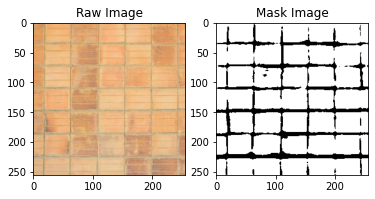

Total Contours Found:  33


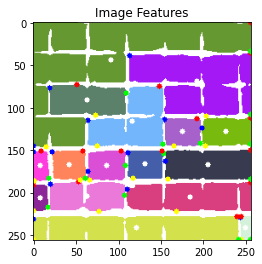

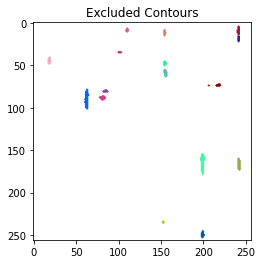

N = Mean contour height /2 : 22.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
15  13584.5   91   44    (91, 44)  ...    NaN  13664.5   1    True
13   2839.0   63   91    (63, 91)  ...    NaN   2839.0   2   False
14   7352.5  192   69   (192, 69)  ...    NaN   7353.0   2   False
12   3959.0  116  116  (116, 116)  ...    NaN   3959.0   3   False
10   1259.0  175  128  (175, 128)  ...    NaN   1259.0   3   False
11   1707.5  226  128  (226, 128)  ...    NaN   1707.5   3   False
8     565.5    8  168    (8, 168)  ...    NaN    565.5   4   False
7    1208.5   42  167   (42, 167)  ...    NaN   1208.5   4   False
6    1386.0   86  168   (86, 168)  ...    NaN   1386.0   4   False
5    1259.0  131  166  (131, 166)  ...    NaN   1259.0   4   False
9    3252.0  205  167  (205, 167)  ...    NaN   3252.0   4   False
2     481.0    8  206    (8, 206)  ...    NaN    481.0   5   False
4    2537.5   63  204   (63, 204)  ...    NaN   2537.5   5   False
3    4168.5  184  205  (184, 205)  ...    NaN   4169.5   5   False
1    6120.5  121  241  (121, 241)  ...    NaN   6124.0   6    True
0     305.0  249  241  (249, 241)  ...    NaN    305.0   6   False

[16 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
13  2839.0   63   91    (63, 91)  ...    NaN   2839.0   2   False
14  7352.5  192   69   (192, 69)  ...    NaN   7353.0   2   False
12  3959.0  116  116  (116, 116)  ...    NaN   3959.0   3   False
10  1259.0  175  128  (175, 128)  ...    NaN   1259.0   3   False
11  1707.5  226  128  (226, 128)  ...    NaN   1707.5   3   False
8    565.5    8  168    (8, 168)  ...    NaN    565.5   4   False
7   1208.5   42  167   (42, 167)  ...    NaN   1208.5   4   False
6   1386.0   86  168   (86, 168)  ...    NaN   1386.0   4   False
5   1259.0  131  166  (131, 166)  ...    NaN   1259.0   4   False
9   3252.0  205  167  (205, 167)  ...    NaN   3252.0   4   False
2    481.0    8  206    (8, 206)  ...    NaN    481.0   5   False
4   2537.5   63  204   (63, 204)  ...    NaN   2537.5   5   False
3   4168.5  184  205  (184, 205)  ...    NaN   4169.5   5   False
0    305.0  249  241  (249, 241)  ...    NaN    305.0   6   False

[14 rows x 14 columns]

No. of rows:  5
DF Combined:


cxs_combined  count  ... nogo_percent output
1              [63, 116, 175, 192, 226]    5.0  ...         80.0   True
2  [8, 42, 86, 116, 131, 175, 205, 226]    8.0  ...         50.0   True
3     [8, 8, 42, 63, 86, 131, 184, 205]    8.0  ...         75.0   True
4                     [8, 63, 184, 249]    4.0  ...          0.0  False

[4 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row                     cX  ... count           Mortar Thickness Vertical
0    2              [63, 192]  ...     2                           [[4, 44]]
1    3        [116, 175, 226]  ...     3                  [[2, 29], [2, 18]]
2    4  [8, 42, 86, 131, 205]  ...     5  [[4, 31], [3, 8], [3, 15], [2, 9]]
3    5           [8, 63, 184]  ...     3                   [[3, 27], [3, 7]]
4    6                  [249]  ...     1                                  []

[5 rows x 10 columns]

Annotation 2020-06-10 095623.png


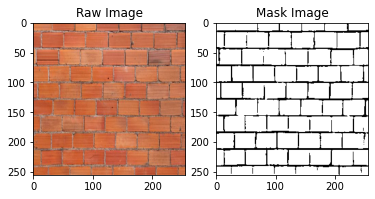

Total Contours Found:  62


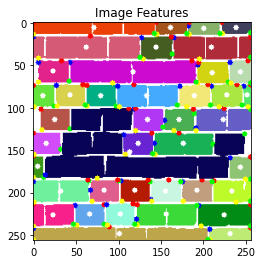

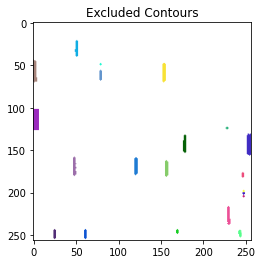

N = Mean contour height /2 : 12.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
40  1830.5   71    6     (71, 6)  ...    NaN   1830.5   1    True
39   485.0  161    6    (161, 6)  ...    NaN    485.0   1   False
38   505.5  200    7    (200, 7)  ...    NaN    505.5   1   False
37   427.0  238    6    (238, 6)  ...    NaN    427.0   1   False
36  2952.0   62   29    (62, 29)  ...    NaN   2952.0   2   False
35   888.0  144   29   (144, 29)  ...    NaN    888.0   2   False
34  2116.0  209   29   (209, 29)  ...    NaN   2116.0   2   False
33   842.5   23   57    (23, 57)  ...    NaN    842.5   3   False
32  3618.0  117   58   (117, 58)  ...    NaN   3618.0   3    True
30   848.5  210   59   (210, 59)  ...    NaN    848.5   3   False
31   610.0  243   58   (243, 58)  ...    NaN    610.0   3   False
24   585.0   11   86    (11, 86)  ...    NaN    585.0   4   False
29   795.5   43   85    (43, 85)  ...    NaN    795.5   4   False
23   801.5   79   86    (79, 86)  ...    NaN    801.5   4   False
28  1631.0  133   86   (133, 86)  ...    NaN   1631.0   4   False
27   854.0  189   86   (189, 86)  ...    NaN    854.0   4   False
26   875.5  227   85   (227, 85)  ...    NaN    875.5   4   False
25   180.5  251   85   (251, 85)  ...    NaN    180.5   4   False
19   794.5   25  114   (25, 114)  ...    NaN    794.5   5   False
21   842.0  134  114  (134, 114)  ...    NaN    842.0   5   False
18   822.0  171  114  (171, 114)  ...    NaN    822.0   5   False
20  1502.5  223  114  (223, 114)  ...    NaN   1502.5   5   False
17   753.5   15  142   (15, 142)  ...    NaN    753.5   6   False
22  9309.0  113  152  (113, 152)  ...    NaN   9234.5   6    True
16   827.0  123  142  (123, 142)  ...    NaN    827.0   6   False
15  1651.5  176  142  (176, 142)  ...    NaN   1651.5   6   False
14   269.0    5  169    (5, 169)  ...    NaN    269.0   7   False
13   595.5  243  170  (243, 170)  ...    NaN    595.5   7   False
12  1472.0   32  198   (32, 198)  ...    NaN   1472.0   8   False
11   776.5   83  197   (83, 197)  ...    NaN    776.5   8   False
10   803.0  119  197  (119, 197)  ...    NaN    803.0   8   False
9    814.0  155  198  (155, 198)  ...    NaN    814.0   8   False
8    817.0  192  197  (192, 197)  ...    NaN    817.0   8   False
7    997.5  233  198  (233, 198)  ...    NaN    997.5   8   False
6   1056.5   23  226   (23, 226)  ...    NaN   1056.5   9   False
4    789.0   66  225   (66, 225)  ...    NaN    789.0   9   False
5    779.0  102  225  (102, 225)  ...    NaN    779.0   9   False
3   1605.5  156  225  (156, 225)  ...    NaN   1605.5   9   False
2   1493.0  224  226  (224, 226)  ...    NaN   1493.0   9   False
1   2660.5  101  248  (101, 248)  ...    NaN   2661.0  10    True
0    617.0  231  248  (231, 248)  ...    NaN    617.0  10   False

[41 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
39   485.0  161    6    (161, 6)  ...    NaN    485.0   1   False
38   505.5  200    7    (200, 7)  ...    NaN    505.5   1   False
37   427.0  238    6    (238, 6)  ...    NaN    427.0   1   False
36  2952.0   62   29    (62, 29)  ...    NaN   2952.0   2   False
35   888.0  144   29   (144, 29)  ...    NaN    888.0   2   False
34  2116.0  209   29   (209, 29)  ...    NaN   2116.0   2   False
33   842.5   23   57    (23, 57)  ...    NaN    842.5   3   False
30   848.5  210   59   (210, 59)  ...    NaN    848.5   3   False
31   610.0  243   58   (243, 58)  ...    NaN    610.0   3   False
24   585.0   11   86    (11, 86)  ...    NaN    585.0   4   False
29   795.5   43   85    (43, 85)  ...    NaN    795.5   4   False
23   801.5   79   86    (79, 86)  ...    NaN    801.5   4   False
28  1631.0  133   86   (133, 86)  ...    NaN   1631.0   4   False
27   854.0  189   86   (189, 86)  ...    NaN    854.0   4   False
26   875.5  227   85   (227, 85)  ...    NaN    875.5   4   False
25   180.5  251   85   (251, 85)  ...    NaN    180.5   4   False
19   794.5   25  114   (25, 114)  ...    NaN    794.5   5   False
21   842.0  134  114  (134, 114)  ...    NaN    842.0   5   False
18   822.0  171  114  (171, 114)  ...    NaN    822.0   5   False
20  1502.5  223  114  (223, 114)  ...    NaN   1502.5   5   False
17   753.5   15  142   (15, 142)  ...    NaN    753.5   6   False
16   827.0  123  142  (123, 142)  ...    NaN    827.0   6   False
15  1651.5  176  142  (176, 142)  ...    NaN   1651.5   6   False
14   269.0    5  169    (5, 169)  ...    NaN    269.0   7   False
13   595.5  243  170  (243, 170)  ...    NaN    595.5   7   False
12  1472.0   32  198   (32, 198)  ...    NaN   1472.0   8   False
11   776.5   83  197   (83, 197)  ...    NaN    776.5   8   False
10   803.0  119  197  (119, 197)  ...    NaN    803.0   8   False
9    814.0  155  198  (155, 198)  ...    NaN    814.0   8   False
8    817.0  192  197  (192, 197)  ...    NaN    817.0   8   False
7    997.5  233  198  (233, 198)  ...    NaN    997.5   8   False
6   1056.5   23  226   (23, 226)  ...    NaN   1056.5   9   False
4    789.0   66  225   (66, 225)  ...    NaN    789.0   9   False
5    779.0  102  225  (102, 225)  ...    NaN    779.0   9   False
3   1605.5  156  225  (156, 225)  ...    NaN   1605.5   9   False
2   1493.0  224  226  (224, 226)  ...    NaN   1493.0   9   False
0    617.0  231  248  (231, 248)  ...    NaN    617.0  10   False

[37 rows x 14 columns]

No. of rows:  10
DF Combined:


cxs_combined  ...  output
1                      [62, 144, 161, 200, 209, 238]  ...   False
2                       [23, 62, 144, 209, 210, 243]  ...   False
3     [11, 23, 43, 79, 133, 189, 210, 227, 243, 251]  ...   False
4  [11, 25, 43, 79, 133, 134, 171, 189, 223, 227,...  ...   False
5                  [15, 25, 123, 134, 171, 176, 223]  ...    True
6                             [5, 15, 123, 176, 243]  ...   False
7               [5, 32, 83, 119, 155, 192, 233, 243]  ...   False
8  [23, 32, 66, 83, 102, 119, 155, 156, 192, 224,...  ...    True
9                       [23, 66, 102, 156, 224, 231]  ...   False

[9 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row  ...                          Mortar Thickness Vertical
0    1  ...                                  [[2, 9], [2, 13]]
1    2  ...                                 [[2, 23], [2, 19]]
2    3  ...                               [[151, 19], [2, 23]]
3    4  ...  [[3, 24], [2, 23], [2, 23], [3, 22], [1, 22], ...
4    5  ...                        [[75, 23], [2, 8], [2, 17]]
5    6  ...                                [[74, 17], [2, 12]]
6    7  ...                                        [[219, 23]]
7    8  ...         [[2, 11], [3, 0], [1, 21], [2, 0], [2, 1]]
8    9  ...                 [[2, 22], [3, 23], [2, 6], [2, 0]]
9   10  ...                                                 []

[10 rows x 10 columns]

bw40.png


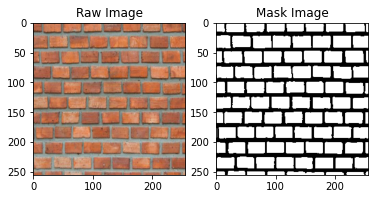

Total Contours Found:  94


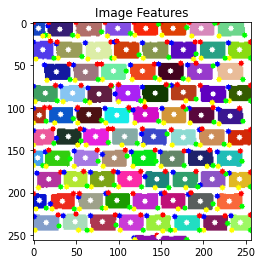

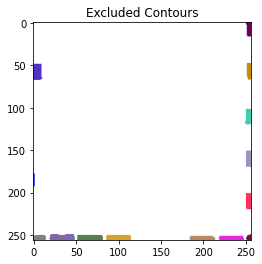

N = Mean contour height /2 : 9.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
79  203.0    6    7      (6, 7)  ...    NaN    203.0   1   False
78  458.5   31    8     (31, 8)  ...    NaN    458.5   1   False
77  458.5   65    7     (65, 7)  ...    NaN    458.5   1   False
76  438.0   99    7     (99, 7)  ...    NaN    438.0   1   False
75  415.5  132    7    (132, 7)  ...    NaN    415.5   1   False
..    ...  ...  ...         ...  ...    ...      ...  ..     ...
4   488.0  147  235  (147, 235)  ...    NaN    488.0  10   False
2   492.5  180  235  (180, 235)  ...    NaN    492.5  10   False
1   465.5  213  235  (213, 235)  ...    NaN    465.5  10   False
3   397.0  243  235  (243, 235)  ...    NaN    397.0  10   False
0   253.0  147  252  (147, 252)  ...    NaN    253.0  11    True

[80 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
79  203.0    6    7      (6, 7)  ...    NaN    203.0   1   False
78  458.5   31    8     (31, 8)  ...    NaN    458.5   1   False
77  458.5   65    7     (65, 7)  ...    NaN    458.5   1   False
76  438.0   99    7     (99, 7)  ...    NaN    438.0   1   False
75  415.5  132    7    (132, 7)  ...    NaN    415.5   1   False
..    ...  ...  ...         ...  ...    ...      ...  ..     ...
5   499.5  114  235  (114, 235)  ...    NaN    499.5  10   False
4   488.0  147  235  (147, 235)  ...    NaN    488.0  10   False
2   492.5  180  235  (180, 235)  ...    NaN    492.5  10   False
1   465.5  213  235  (213, 235)  ...    NaN    465.5  10   False
3   397.0  243  235  (243, 235)  ...    NaN    397.0  10   False

[76 rows x 14 columns]

No. of rows:  10
DF Combined:


cxs_combined  ...  output
1  [6, 11, 31, 41, 65, 99, 109, 132, 164, 176, 19...  ...   False
2  [11, 27, 41, 61, 94, 109, 128, 161, 176, 195, ...  ...   False
3  [14, 27, 46, 61, 77, 94, 111, 128, 143, 161, 1...  ...   False
4  [7, 14, 32, 46, 65, 77, 98, 111, 131, 143, 165...  ...   False
5  [7, 11, 32, 41, 65, 73, 98, 107, 131, 141, 165...  ...    True
6  [5, 11, 28, 41, 61, 73, 95, 107, 129, 141, 163...  ...   False
7  [5, 18, 28, 49, 61, 80, 95, 113, 129, 145, 163...  ...   False
8  [7, 18, 34, 49, 67, 80, 98, 113, 131, 145, 164...  ...   False
9  [7, 15, 34, 49, 67, 81, 98, 114, 131, 147, 164...  ...   False

[9 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row  ...                          Mortar Thickness Vertical
0    1  ...  [[3, 11], [4, 15], [4, 11], [4, 13], [3, 2], [...
1    2  ...    [[3, 17], [38, 17], [38, 14], [5, 14], [4, 18]]
2    3  ...  [[4, 17], [4, 18], [5, 7], [4, 16], [5, 16], [...
3    4  ...  [[4, 17], [3, 15], [4, 9], [2, 16], [4, 0], [5...
4    5  ...  [[4, 16], [4, 11], [4, 14], [4, 0], [4, 15], [...
5    6  ...  [[3, 6], [3, 13], [5, 16], [5, 11], [5, 5], [4...
6    7  ...  [[3, 16], [5, 9], [5, 8], [5, 5], [5, 11], [5,...
7    8  ...  [[4, 17], [4, 16], [4, 15], [4, 12], [5, 18], ...
8    9  ...  [[5, 5], [5, 14], [4, 17], [4, 16], [4, 17], [...
9   10  ...  [[5, 12], [4, 17], [4, 11], [4, 17], [5, 16], ...

[10 rows x 10 columns]

bw44.png


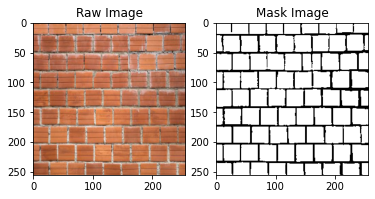

Total Contours Found:  78


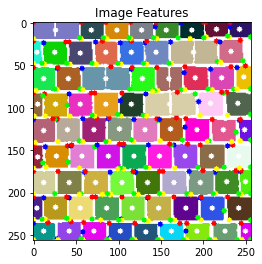

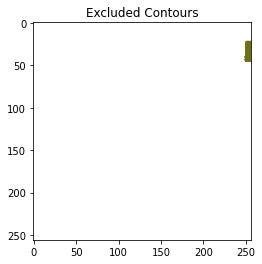

N = Mean contour height /2 : 13.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
76  958.0   26    9     (26, 9)  ...    NaN    958.0   1    True
75  493.5   68    9     (68, 9)  ...    NaN    493.5   1   False
74  493.0   98    9     (98, 9)  ...    NaN    493.0   1   False
73  495.0  127    9    (127, 9)  ...    NaN    495.0   1   False
72  475.0  156    9    (156, 9)  ...    NaN    475.0   1   False
..    ...  ...  ...         ...  ...    ...      ...  ..     ...
4   477.0  132  246  (132, 246)  ...    NaN    477.0   9   False
3   475.0  162  245  (162, 245)  ...    NaN    475.0   9   False
2   490.5  192  245  (192, 245)  ...    NaN    490.5   9   False
1   492.0  225  245  (225, 245)  ...    NaN    492.0   9   False
0   208.5  249  245  (249, 245)  ...    NaN    208.5   9   False

[77 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
75  493.5   68    9     (68, 9)  ...    NaN    493.5   1   False
74  493.0   98    9     (98, 9)  ...    NaN    493.0   1   False
73  495.0  127    9    (127, 9)  ...    NaN    495.0   1   False
72  475.0  156    9    (156, 9)  ...    NaN    475.0   1   False
71  496.5  186    9    (186, 9)  ...    NaN    496.5   1   False
..    ...  ...  ...         ...  ...    ...      ...  ..     ...
4   477.0  132  246  (132, 246)  ...    NaN    477.0   9   False
3   475.0  162  245  (162, 245)  ...    NaN    475.0   9   False
2   490.5  192  245  (192, 245)  ...    NaN    490.5   9   False
1   492.0  225  245  (225, 245)  ...    NaN    492.0   9   False
0   208.5  249  245  (249, 245)  ...    NaN    208.5   9   False

[71 rows x 14 columns]

No. of rows:  9
DF Combined:


cxs_combined  ...  output
1  [4, 25, 55, 68, 85, 98, 115, 127, 144, 156, 18...  ...   False
2  [4, 12, 25, 41, 55, 85, 115, 128, 144, 190, 22...  ...   False
3  [5, 12, 26, 41, 55, 85, 115, 128, 190, 221, 24...  ...   False
4  [5, 12, 26, 40, 55, 71, 85, 101, 115, 131, 161...  ...   False
5  [5, 12, 27, 40, 57, 71, 88, 101, 118, 131, 148...  ...   False
6  [5, 12, 27, 42, 57, 73, 88, 104, 118, 134, 148...  ...   False
7  [4, 12, 26, 42, 55, 73, 86, 104, 116, 134, 147...  ...   False
8  [4, 12, 26, 42, 55, 71, 86, 102, 116, 132, 147...  ...   False

[8 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row  ...                          Mortar Thickness Vertical
0    1  ...  [[3, 18], [2, 18], [2, 13], [3, 17], [2, 18], ...
1    2  ...  [[2, 24], [3, 25], [4, 25], [3, 24], [2, 24], ...
2    3  ...    [[3, 24], [60, 23], [35, 21], [3, 23], [4, 25]]
3    4  ...      [[2, 2], [2, 13], [3, 26], [3, 16], [98, 27]]
4    5  ...  [[2, 0], [4, 26], [3, 27], [3, 24], [2, 1], [3...
5    6  ...  [[3, 19], [3, 19], [3, 2], [3, 27], [3, 26], [...
6    7  ...  [[4, 26], [4, 25], [3, 25], [2, 25], [4, 26], ...
7    8  ...  [[2, 25], [3, 24], [4, 26], [3, 1], [4, 26], [...
8    9  ...  [[2, 1], [2, 8], [2, 1], [3, 19], [3, 18], [3,...

[9 rows x 10 columns]

bw53.png


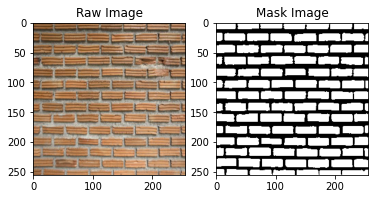

Total Contours Found:  103


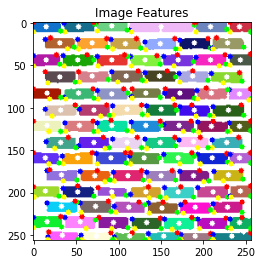

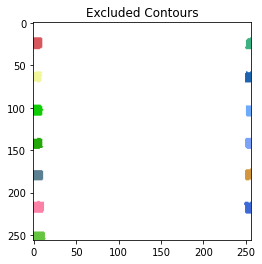

N = Mean contour height /2 : 6.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
89  350.0   15    5     (15, 5)  ...    NaN    350.0   1   False
88  370.5   53    5     (53, 5)  ...    NaN    370.5   1   False
87  356.5   92    4     (92, 4)  ...    NaN    356.5   1   False
86  790.5  150    5    (150, 5)  ...    NaN    790.5   1    True
85  393.5  208    5    (208, 5)  ...    NaN    393.5   1   False
..    ...  ...  ...         ...  ...    ...      ...  ..     ...
4   275.5   74  251   (74, 251)  ...    NaN    275.5  14    True
3   252.0  113  251  (113, 251)  ...    NaN    252.0  14   False
2   275.5  153  251  (153, 251)  ...    NaN    275.5  14   False
0   245.0  190  251  (190, 251)  ...    NaN    245.0  14   False
1   310.0  233  251  (233, 251)  ...    NaN    310.0  14    True

[90 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
89  350.0   15    5     (15, 5)  ...    NaN    350.0   1   False
88  370.5   53    5     (53, 5)  ...    NaN    370.5   1   False
87  356.5   92    4     (92, 4)  ...    NaN    356.5   1   False
85  393.5  208    5    (208, 5)  ...    NaN    393.5   1   False
84  261.0  242    5    (242, 5)  ...    NaN    261.0   1   False
..    ...  ...  ...         ...  ...    ...      ...  ..     ...
8   295.0  242  235  (242, 235)  ...    NaN    295.0  13   False
5   290.5   34  250   (34, 250)  ...    NaN    290.5  14   False
3   252.0  113  251  (113, 251)  ...    NaN    252.0  14   False
2   275.5  153  251  (153, 251)  ...    NaN    275.5  14   False
0   245.0  190  251  (190, 251)  ...    NaN    245.0  14   False

[86 rows x 14 columns]

No. of rows:  14
DF Combined:


cxs_combined  ...  output
1       [15, 31, 53, 69, 92, 108, 149, 189, 208, 242]  ...   False
2   [15, 31, 52, 69, 92, 108, 131, 149, 170, 189, ...  ...   False
3   [15, 31, 52, 69, 92, 109, 131, 148, 170, 187, ...  ...   False
4   [16, 31, 53, 69, 92, 109, 132, 148, 172, 187, ...  ...   False
5   [16, 32, 53, 71, 92, 110, 132, 150, 172, 189, ...  ...   False
6   [16, 32, 54, 71, 92, 110, 132, 150, 171, 189, ...  ...   False
7   [16, 32, 54, 71, 92, 110, 132, 149, 171, 188, ...  ...   False
8   [14, 32, 52, 71, 91, 110, 130, 149, 170, 188, ...  ...   False
9   [14, 33, 52, 72, 91, 111, 130, 150, 170, 188, ...  ...   False
10  [14, 33, 52, 72, 92, 111, 132, 150, 170, 188, ...  ...   False
11  [14, 33, 52, 73, 92, 112, 132, 151, 170, 190, ...  ...   False
12  [16, 33, 55, 73, 94, 112, 133, 151, 171, 190, ...  ...   False
13  [16, 34, 55, 94, 113, 133, 153, 171, 190, 210,...  ...   False

[13 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row  ...                          Mortar Thickness Vertical
0     1  ...                  [[4, 9], [2, 2], [81, 9], [4, 8]]
1     2  ...                  [[4, 9], [4, 9], [5, 7], [5, 10]]
2     3  ...  [[4, 10], [4, 4], [3, 0], [4, 9], [3, 5], [5, 9]]
3     4  ...          [[4, 12], [4, 9], [3, 9], [4, 4], [4, 8]]
4     5  ...   [[4, 0], [4, 9], [4, 4], [5, 5], [3, 9], [2, 0]]
5     6  ...        [[4, 4], [4, 11], [5, 10], [4, 4], [4, 10]]
6     7  ...  [[5, 10], [4, 10], [5, 10], [3, 1], [5, 10], [...
7     8  ...         [[3, 2], [4, 10], [4, 10], [4, 7], [5, 9]]
8     9  ...   [[4, 8], [5, 1], [4, 8], [5, 4], [4, 2], [3, 9]]
9    10  ...        [[4, 10], [4, 9], [4, 9], [5, 10], [6, 11]]
10   11  ...  [[5, 9], [5, 10], [5, 1], [5, 11], [5, 11], [3...
11   12  ...           [[4, 1], [4, 6], [4, 2], [4, 9], [3, 7]]
12   13  ...  [[4, 11], [4, 3], [5, 10], [4, 11], [5, 0], [3...
13   14  ...                          [[43, 3], [4, 7], [2, 6]]

[14 rows x 10 columns]

c4b5199d3c1366ca55fc8ffa2955e17d.jpg


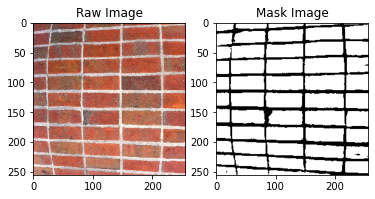

Total Contours Found:  53


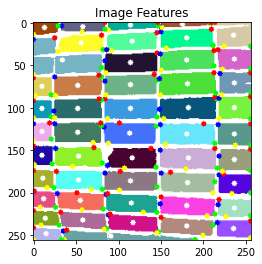

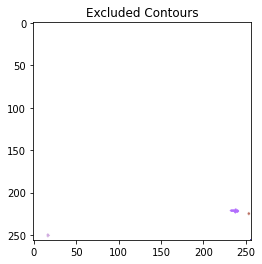

N = Mean contour height /2 : 11.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
48   370.0   13    6     (13, 6)  ...    NaN    370.0   1   False
41   891.0   56   24    (56, 24)  ...    NaN    891.0   1   False
47   506.0   58    5     (58, 5)  ...    NaN    506.0   1   False
46   425.5  114    3    (114, 3)  ...    NaN    425.5   1   False
42  1055.0  116   22   (116, 22)  ...    NaN   1055.0   1   False
45   246.0  175    2    (175, 2)  ...    NaN    246.0   1   False
43  1176.5  180   18   (180, 18)  ...    NaN   1176.5   1   False
44   948.5  235   15   (235, 15)  ...    NaN    948.5   1   False
40  1989.5   34   44    (34, 44)  ...    NaN   1989.5   2    True
37  1254.0  114   47   (114, 47)  ...    NaN   1254.0   2   False
38  1339.5  180   44   (180, 44)  ...    NaN   1339.5   2   False
39   828.0  236   43   (236, 43)  ...    NaN    828.0   2   False
32   437.5   10   75    (10, 75)  ...    NaN    437.5   3   False
33  1192.0   52   74    (52, 74)  ...    NaN   1192.0   3   False
34  1323.5  114   73   (114, 73)  ...    NaN   1323.5   3   False
36  1592.5  181   72   (181, 72)  ...    NaN   1592.5   3    True
35   831.5  236   71   (236, 71)  ...    NaN    831.5   3   False
27   418.0   10  101   (10, 101)  ...    NaN    418.0   4   False
29  1177.5   52  101   (52, 101)  ...    NaN   1177.5   4   False
28  1351.0  114  101  (114, 101)  ...    NaN   1351.0   4   False
30  1527.5  182  100  (182, 100)  ...    NaN   1527.5   4    True
31   923.0  236  100  (236, 100)  ...    NaN    923.0   4   False
26   428.0   10  128   (10, 128)  ...    NaN    428.0   5   False
25  1174.0   52  129   (52, 129)  ...    NaN   1174.0   5   False
24  1371.5  113  130  (113, 130)  ...    NaN   1371.5   5   False
23  1461.5  180  131  (180, 131)  ...    NaN   1461.5   5   False
22   929.5  236  131  (236, 131)  ...    NaN    929.5   5   False
21   469.5   10  156   (10, 156)  ...    NaN    469.5   6   False
20  1123.0   53  157   (53, 157)  ...    NaN   1123.0   6   False
19  1194.5  116  159  (116, 159)  ...    NaN   1194.5   6   False
18  1480.5  182  159  (182, 159)  ...    NaN   1480.5   6    True
17   883.0  236  161  (236, 161)  ...    NaN    883.0   6   False
16   444.0   11  183   (11, 183)  ...    NaN    444.0   7   False
15  1066.0   53  185   (53, 185)  ...    NaN   1066.0   7   False
14  1264.5  114  186  (114, 186)  ...    NaN   1264.5   7   False
13  1327.5  181  188  (181, 188)  ...    NaN   1327.5   7   False
12   793.5  236  189  (236, 189)  ...    NaN    793.5   7   False
11   438.0   12  207   (12, 207)  ...    NaN    438.0   8   False
10   970.5   55  209   (55, 209)  ...    NaN    970.5   8   False
9   1136.0  115  212  (115, 212)  ...    NaN   1136.0   8   False
8   1210.0  180  215  (180, 215)  ...    NaN   1210.0   8   False
7    722.0  236  218  (236, 218)  ...    NaN    722.0   8   False
6    453.5   14  230   (14, 230)  ...    NaN    453.5   9   False
1    405.5   15  248   (15, 248)  ...    NaN    405.5   9   False
5    864.0   58  232   (58, 232)  ...    NaN    864.0   9   False
0    864.0   91  251   (91, 251)  ...    NaN    864.0   9    True
4    947.0  117  235  (117, 235)  ...    NaN    947.0   9   False
3   1011.5  180  239  (180, 239)  ...    NaN   1011.5   9   False
2    717.0  235  242  (235, 242)  ...    NaN    717.0   9   False

[49 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
48   370.0   13    6     (13, 6)  ...    NaN    370.0   1   False
41   891.0   56   24    (56, 24)  ...    NaN    891.0   1   False
47   506.0   58    5     (58, 5)  ...    NaN    506.0   1   False
46   425.5  114    3    (114, 3)  ...    NaN    425.5   1   False
42  1055.0  116   22   (116, 22)  ...    NaN   1055.0   1   False
45   246.0  175    2    (175, 2)  ...    NaN    246.0   1   False
43  1176.5  180   18   (180, 18)  ...    NaN   1176.5   1   False
44   948.5  235   15   (235, 15)  ...    NaN    948.5   1   False
37  1254.0  114   47   (114, 47)  ...    NaN   1254.0   2   False
38  1339.5  180   44   (180, 44)  ...    NaN   1339.5   2   False
39   828.0  236   43   (236, 43)  ...    NaN    828.0   2   False
32   437.5   10   75    (10, 75)  ...    NaN    437.5   3   False
33  1192.0   52   74    (52, 74)  ...    NaN   1192.0   3   False
34  1323.5  114   73   (114, 73)  ...    NaN   1323.5   3   False
35   831.5  236   71   (236, 71)  ...    NaN    831.5   3   False
27   418.0   10  101   (10, 101)  ...    NaN    418.0   4   False
29  1177.5   52  101   (52, 101)  ...    NaN   1177.5   4   False
28  1351.0  114  101  (114, 101)  ...    NaN   1351.0   4   False
31   923.0  236  100  (236, 100)  ...    NaN    923.0   4   False
26   428.0   10  128   (10, 128)  ...    NaN    428.0   5   False
25  1174.0   52  129   (52, 129)  ...    NaN   1174.0   5   False
24  1371.5  113  130  (113, 130)  ...    NaN   1371.5   5   False
23  1461.5  180  131  (180, 131)  ...    NaN   1461.5   5   False
22   929.5  236  131  (236, 131)  ...    NaN    929.5   5   False
21   469.5   10  156   (10, 156)  ...    NaN    469.5   6   False
20  1123.0   53  157   (53, 157)  ...    NaN   1123.0   6   False
19  1194.5  116  159  (116, 159)  ...    NaN   1194.5   6   False
17   883.0  236  161  (236, 161)  ...    NaN    883.0   6   False
16   444.0   11  183   (11, 183)  ...    NaN    444.0   7   False
15  1066.0   53  185   (53, 185)  ...    NaN   1066.0   7   False
14  1264.5  114  186  (114, 186)  ...    NaN   1264.5   7   False
13  1327.5  181  188  (181, 188)  ...    NaN   1327.5   7   False
12   793.5  236  189  (236, 189)  ...    NaN    793.5   7   False
11   438.0   12  207   (12, 207)  ...    NaN    438.0   8   False
10   970.5   55  209   (55, 209)  ...    NaN    970.5   8   False
9   1136.0  115  212  (115, 212)  ...    NaN   1136.0   8   False
8   1210.0  180  215  (180, 215)  ...    NaN   1210.0   8   False
7    722.0  236  218  (236, 218)  ...    NaN    722.0   8   False
6    453.5   14  230   (14, 230)  ...    NaN    453.5   9   False
1    405.5   15  248   (15, 248)  ...    NaN    405.5   9   False
5    864.0   58  232   (58, 232)  ...    NaN    864.0   9   False
4    947.0  117  235  (117, 235)  ...    NaN    947.0   9   False
3   1011.5  180  239  (180, 239)  ...    NaN   1011.5   9   False
2    717.0  235  242  (235, 242)  ...    NaN    717.0   9   False

[44 rows x 14 columns]

No. of rows:  9
DF Combined:


cxs_combined  ...  output
1  [13, 56, 58, 114, 114, 116, 175, 180, 180, 235...  ...    True
2                  [10, 52, 114, 114, 180, 236, 236]  ...    True
3               [10, 10, 52, 52, 114, 114, 236, 236]  ...    True
4          [10, 10, 52, 52, 113, 114, 180, 236, 236]  ...    True
5          [10, 10, 52, 53, 113, 116, 180, 236, 236]  ...    True
6          [10, 11, 53, 53, 114, 116, 181, 236, 236]  ...    True
7     [11, 12, 53, 55, 114, 115, 180, 181, 236, 236]  ...    True
8  [12, 14, 15, 55, 58, 115, 117, 180, 180, 235, ...  ...    True

[8 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row  ...                          Mortar Thickness Vertical
0    1  ...  [[0, 30], [49, 28], [4, 1], [60, 28], [5, 7], ...
1    2  ...                                  [[4, 1], [5, 19]]
2    3  ...                         [[4, 21], [4, 5], [74, 8]]
3    4  ...                         [[3, 7], [4, 1], [73, 22]]
4    5  ...                 [[4, 18], [3, 2], [5, 2], [4, 22]]
5    6  ...                        [[4, 18], [6, 3], [74, 13]]
6    7  ...                [[3, 19], [3, 19], [5, 16], [5, 8]]
7    8  ...               [[2, 16], [3, 17], [4, 10], [4, 11]]
8    9  ...       [[30, 3], [1, 32], [2, 16], [3, 17], [5, 3]]

[9 rows x 10 columns]

d863ab3cf81115c60c00bb5fa0f6e181.jpg


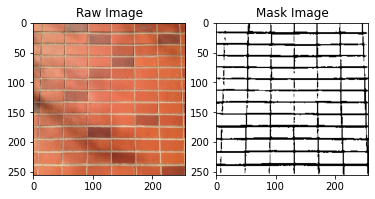

Total Contours Found:  73


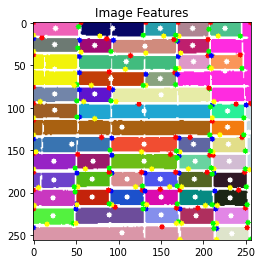

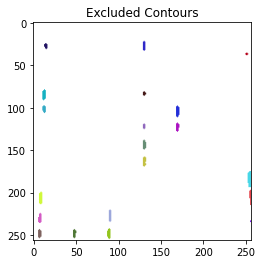

N = Mean contour height /2 : 10.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
52   782.5   26    7     (26, 7)  ...    NaN    782.5   1   False
51  1076.0   93    7     (93, 7)  ...    NaN   1076.0   1   False
50   539.0  149    7    (149, 7)  ...    NaN    539.0   1   False
49   563.0  187    7    (187, 7)  ...    NaN    563.0   1   False
48   550.5  225    7    (225, 7)  ...    NaN    550.5   1   False
46   777.5   25   26    (25, 26)  ...    NaN    777.5   2   False
45   549.0   72   27    (72, 27)  ...    NaN    549.0   2   False
44  1076.5  131   28   (131, 28)  ...    NaN   1076.5   2   False
43   559.5  187   27   (187, 27)  ...    NaN    559.5   2   False
42  1553.5   25   55    (25, 55)  ...    NaN   1553.5   3   False
38  1105.0   91   66    (91, 66)  ...    NaN   1105.0   3   False
40  1608.5  109   46   (109, 46)  ...    NaN   1608.5   3    True
37   518.0  149   66   (149, 66)  ...    NaN    518.0   3   False
39   523.5  188   46   (188, 46)  ...    NaN    523.5   3   False
47  2839.5  225   57   (225, 57)  ...    NaN   2847.0   3   False
41   549.5  227   46   (227, 46)  ...    NaN    549.5   3   False
36   792.0   25   84    (25, 84)  ...    NaN    792.0   4   False
35   579.0   72   84    (72, 84)  ...    NaN    579.0   4   False
34  1699.5  150   85   (150, 85)  ...    NaN   1699.5   4    True
33   802.5   25  103   (25, 103)  ...    NaN    802.5   5   False
31  2247.5  130  104  (130, 104)  ...    NaN   2247.5   5    True
30   566.0  228  104  (228, 104)  ...    NaN    566.0   5   False
29  3173.0  104  123  (104, 123)  ...    NaN   3174.5   6    True
28   583.0  228  123  (228, 123)  ...    NaN    583.0   6   False
32   246.0  253  129  (253, 129)  ...    NaN    246.0   6   False
27  1367.0   45  143   (45, 143)  ...    NaN   1367.0   7    True
26  1223.5  130  143  (130, 143)  ...    NaN   1223.5   7   False
25   590.5  188  143  (188, 143)  ...    NaN    590.5   7   False
24   603.5  229  143  (229, 143)  ...    NaN    603.5   7   False
23   829.5   24  163   (24, 163)  ...    NaN    829.5   8   False
22   604.5   70  163   (70, 163)  ...    NaN    604.5   8   False
21  1221.0  130  163  (130, 163)  ...    NaN   1221.0   8   False
20   570.0  190  163  (190, 163)  ...    NaN    570.0   8   False
19   595.5  230  163  (230, 163)  ...    NaN    595.5   8   False
18   741.0   24  185   (24, 185)  ...    NaN    741.0   9   False
17   619.5   69  184   (69, 184)  ...    NaN    619.5   9   False
16   573.0  110  184  (110, 184)  ...    NaN    573.0   9   False
15   605.5  149  184  (149, 184)  ...    NaN    605.5   9   False
14   633.0  189  184  (189, 184)  ...    NaN    633.0   9   False
13   624.0  231  185  (231, 185)  ...    NaN    624.0   9   False
11   844.5   23  206   (23, 206)  ...    NaN    844.5  10   False
10   634.5   69  205   (69, 205)  ...    NaN    634.5  10   False
9    634.0  110  205  (110, 205)  ...    NaN    634.0  10   False
12   627.0  150  205  (150, 205)  ...    NaN    627.0  10   False
8    631.0  190  205  (190, 205)  ...    NaN    631.0  10   False
7    641.0  231  206  (231, 206)  ...    NaN    641.0  10   False
2    821.0   23  227   (23, 227)  ...    NaN    821.0  11   False
6   1358.5   89  226   (89, 226)  ...    NaN   1358.5  11   False
5    639.5  150  226  (150, 226)  ...    NaN    639.5  11   False
4    659.0  191  227  (191, 227)  ...    NaN    659.0  11   False
3    680.0  232  227  (232, 227)  ...    NaN    680.0  11   False
1   2884.5  104  247  (104, 247)  ...    NaN   2883.5  12    True
0    519.5  233  248  (233, 248)  ...    NaN    519.5  12   False

[53 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
52   782.5   26    7     (26, 7)  ...    NaN    782.5   1   False
51  1076.0   93    7     (93, 7)  ...    NaN   1076.0   1   False
50   539.0  149    7    (149, 7)  ...    NaN    539.0   1   False
49   563.0  187    7    (187, 7)  ...    NaN    563.0   1   False
48   550.5  225    7    (225, 7)  ...    NaN    550.5   1   False
46   777.5   25   26    (25, 26)  ...    NaN    777.5   2   False
45   549.0   72   27    (72, 27)  ...    NaN    549.0   2   False
44  1076.5  131   28   (131, 28)  ...    NaN   1076.5   2   False
43   559.5  187   27   (187, 27)  ...    NaN    559.5   2   False
42  1553.5   25   55    (25, 55)  ...    NaN   1553.5   3   False
38  1105.0   91   66    (91, 66)  ...    NaN   1105.0   3   False
37   518.0  149   66   (149, 66)  ...    NaN    518.0   3   False
39   523.5  188   46   (188, 46)  ...    NaN    523.5   3   False
47  2839.5  225   57   (225, 57)  ...    NaN   2847.0   3   False
41   549.5  227   46   (227, 46)  ...    NaN    549.5   3   False
36   792.0   25   84    (25, 84)  ...    NaN    792.0   4   False
35   579.0   72   84    (72, 84)  ...    NaN    579.0   4   False
33   802.5   25  103   (25, 103)  ...    NaN    802.5   5   False
30   566.0  228  104  (228, 104)  ...    NaN    566.0   5   False
28   583.0  228  123  (228, 123)  ...    NaN    583.0   6   False
32   246.0  253  129  (253, 129)  ...    NaN    246.0   6   False
26  1223.5  130  143  (130, 143)  ...    NaN   1223.5   7   False
25   590.5  188  143  (188, 143)  ...    NaN    590.5   7   False
24   603.5  229  143  (229, 143)  ...    NaN    603.5   7   False
23   829.5   24  163   (24, 163)  ...    NaN    829.5   8   False
22   604.5   70  163   (70, 163)  ...    NaN    604.5   8   False
21  1221.0  130  163  (130, 163)  ...    NaN   1221.0   8   False
20   570.0  190  163  (190, 163)  ...    NaN    570.0   8   False
19   595.5  230  163  (230, 163)  ...    NaN    595.5   8   False
18   741.0   24  185   (24, 185)  ...    NaN    741.0   9   False
17   619.5   69  184   (69, 184)  ...    NaN    619.5   9   False
16   573.0  110  184  (110, 184)  ...    NaN    573.0   9   False
15   605.5  149  184  (149, 184)  ...    NaN    605.5   9   False
14   633.0  189  184  (189, 184)  ...    NaN    633.0   9   False
13   624.0  231  185  (231, 185)  ...    NaN    624.0   9   False
11   844.5   23  206   (23, 206)  ...    NaN    844.5  10   False
10   634.5   69  205   (69, 205)  ...    NaN    634.5  10   False
9    634.0  110  205  (110, 205)  ...    NaN    634.0  10   False
12   627.0  150  205  (150, 205)  ...    NaN    627.0  10   False
8    631.0  190  205  (190, 205)  ...    NaN    631.0  10   False
7    641.0  231  206  (231, 206)  ...    NaN    641.0  10   False
2    821.0   23  227   (23, 227)  ...    NaN    821.0  11   False
6   1358.5   89  226   (89, 226)  ...    NaN   1358.5  11   False
5    639.5  150  226  (150, 226)  ...    NaN    639.5  11   False
4    659.0  191  227  (191, 227)  ...    NaN    659.0  11   False
3    680.0  232  227  (232, 227)  ...    NaN    680.0  11   False
0    519.5  233  248  (233, 248)  ...    NaN    519.5  12   False

[47 rows x 14 columns]

No. of rows:  12
DF Combined:


cxs_combined  ...  output
1           [25, 26, 72, 93, 131, 149, 187, 187, 225]  ...    True
2      [25, 25, 72, 91, 131, 149, 187, 188, 225, 227]  ...    True
3                [25, 25, 72, 91, 149, 188, 225, 227]  ...    True
4                                   [25, 25, 72, 228]  ...    True
5                                 [25, 228, 228, 253]  ...    True
6                           [130, 188, 228, 229, 253]  ...   False
7              [24, 70, 130, 130, 188, 190, 229, 230]  ...    True
8   [24, 24, 69, 70, 110, 130, 149, 189, 190, 230,...  ...    True
9   [23, 24, 69, 69, 110, 110, 149, 150, 189, 190,...  ...    True
10  [23, 23, 69, 89, 110, 150, 150, 190, 191, 231,...  ...    True
11                       [23, 89, 150, 191, 232, 233]  ...   False

[11 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row  ...                       Mortar Thickness Vertical
0     1  ...              [[3, 5], [3, 15], [3, 15], [2, 8]]
1     2  ...                       [[2, 9], [3, 13], [2, 1]]
2     3  ...  [[3, 14], [3, 13], [3, 33], [38, 8], [46, 39]]
3     4  ...                                       [[3, 13]]
4     5  ...                                     [[159, 14]]
5     6  ...                                       [[3, 35]]
6     7  ...                              [[3, 15], [2, 14]]
7     8  ...             [[3, 16], [3, 15], [2, 2], [2, 15]]
8     9  ...     [[3, 16], [2, 1], [3, 15], [2, 15], [2, 1]]
9    10  ...   [[1, 14], [2, 15], [2, 15], [3, 16], [3, 16]]
10   11  ...             [[3, 17], [3, 0], [2, 15], [3, 17]]
11   12  ...                                              []

[12 rows x 10 columns]

sw106.jpg


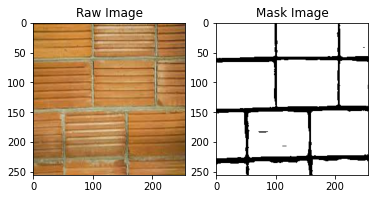

Total Contours Found:  16


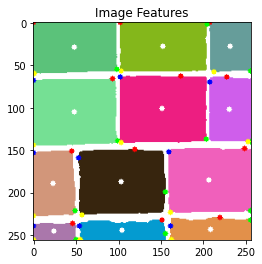

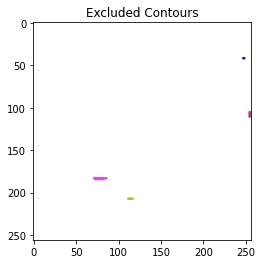

N = Mean contour height /2 : 29.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
11  5642.5   48   29    (48, 29)  ...    NaN   5642.5   1   False
10  5719.0  152   28   (152, 28)  ...    NaN   5719.0   1    True
9   2669.5  231   28   (231, 28)  ...    NaN   2669.5   1   False
6   7341.5   48  105   (48, 105)  ...    NaN   7341.5   2   False
8   7669.0  151  101  (151, 101)  ...    NaN   7669.0   2   False
7   3541.5  230  102  (230, 102)  ...    NaN   3541.5   2   False
3   3551.0   23  189   (23, 189)  ...    NaN   3551.0   3   False
4   7315.0  103  187  (103, 187)  ...    NaN   7315.0   3    True
5   7045.5  206  185  (206, 185)  ...    NaN   7045.5   3   False
0    908.5   24  245   (24, 245)  ...    NaN    908.5   4   False
1   2076.0  104  244  (104, 244)  ...    NaN   2076.0   4   False
2   2238.5  208  243  (208, 243)  ...    NaN   2238.5   4   False

[12 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
11  5642.5   48   29    (48, 29)  ...    NaN   5642.5   1   False
9   2669.5  231   28   (231, 28)  ...    NaN   2669.5   1   False
6   7341.5   48  105   (48, 105)  ...    NaN   7341.5   2   False
8   7669.0  151  101  (151, 101)  ...    NaN   7669.0   2   False
7   3541.5  230  102  (230, 102)  ...    NaN   3541.5   2   False
3   3551.0   23  189   (23, 189)  ...    NaN   3551.0   3   False
5   7045.5  206  185  (206, 185)  ...    NaN   7045.5   3   False
0    908.5   24  245   (24, 245)  ...    NaN    908.5   4   False
1   2076.0  104  244  (104, 244)  ...    NaN   2076.0   4   False
2   2238.5  208  243  (208, 243)  ...    NaN   2238.5   4   False

[10 rows x 14 columns]

No. of rows:  4
DF Combined:


cxs_combined  count  ... nogo_percent output
1  [48, 48, 151, 230, 231]    5.0  ...         80.0   True
2  [23, 48, 151, 206, 230]    5.0  ...         40.0  False
3  [23, 24, 104, 206, 208]    5.0  ...         80.0   True

[3 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row              cX  ... count Mortar Thickness Vertical
0    1       [48, 231]  ...     2               [[109, 55]]
1    2  [48, 151, 230]  ...     3        [[3, 75], [4, 67]]
2    3       [23, 206]  ...     2               [[110, 69]]
3    4  [24, 104, 208]  ...     3         [[4, 16], [6, 9]]

[4 rows x 10 columns]

sw12232323.png


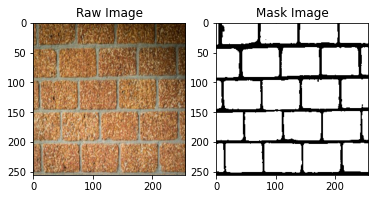

Total Contours Found:  26


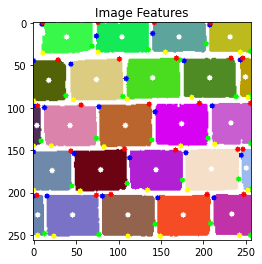

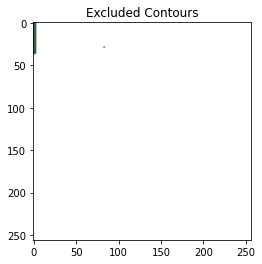

N = Mean contour height /2 : 23.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
23  1999.5   39   17    (39, 17)  ...    NaN   1999.5   1   False
22  2078.5  104   17   (104, 17)  ...    NaN   2078.5   1   False
21  2093.0  171   17   (171, 17)  ...    NaN   2093.0   1    True
20  1637.0  231   17   (231, 17)  ...    NaN   1637.0   1   False
15  1745.5   18   68    (18, 68)  ...    NaN   1745.5   2   False
16  2817.0   74   67    (74, 67)  ...    NaN   2817.0   2   False
19  2823.5  140   65   (140, 65)  ...    NaN   2823.5   2    True
18  2704.0  207   65   (207, 65)  ...    NaN   2704.0   2   False
17   518.5  249   64   (249, 64)  ...    NaN    518.5   2   False
10   369.5    4  121    (4, 121)  ...    NaN    369.5   3   False
11  2784.5   43  121   (43, 121)  ...    NaN   2784.5   3   False
12  2934.5  108  121  (108, 121)  ...    NaN   2934.5   3   False
14  2873.5  174  119  (174, 119)  ...    NaN   2873.5   3   False
13  2106.0  232  118  (232, 118)  ...    NaN   2106.0   3   False
5   1994.5   22  174   (22, 174)  ...    NaN   1994.5   4   False
9   2809.5   79  173   (79, 173)  ...    NaN   2809.5   4   False
6   2788.5  144  173  (144, 173)  ...    NaN   2788.5   4   False
8   2916.5  209  172  (209, 172)  ...    NaN   2916.5   4   False
7    461.0  250  171  (250, 171)  ...    NaN    461.0   4   False
1    547.5    5  226    (5, 226)  ...    NaN    547.5   5   False
0   2841.5   46  226   (46, 226)  ...    NaN   2841.5   5   False
4   2861.0  111  226  (111, 226)  ...    NaN   2861.0   5   False
3   2844.5  176  226  (176, 226)  ...    NaN   2844.5   5   False
2   1987.5  233  225  (233, 225)  ...    NaN   1987.5   5   False

[24 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
23  1999.5   39   17    (39, 17)  ...    NaN   1999.5   1   False
22  2078.5  104   17   (104, 17)  ...    NaN   2078.5   1   False
20  1637.0  231   17   (231, 17)  ...    NaN   1637.0   1   False
15  1745.5   18   68    (18, 68)  ...    NaN   1745.5   2   False
16  2817.0   74   67    (74, 67)  ...    NaN   2817.0   2   False
18  2704.0  207   65   (207, 65)  ...    NaN   2704.0   2   False
17   518.5  249   64   (249, 64)  ...    NaN    518.5   2   False
10   369.5    4  121    (4, 121)  ...    NaN    369.5   3   False
11  2784.5   43  121   (43, 121)  ...    NaN   2784.5   3   False
12  2934.5  108  121  (108, 121)  ...    NaN   2934.5   3   False
14  2873.5  174  119  (174, 119)  ...    NaN   2873.5   3   False
13  2106.0  232  118  (232, 118)  ...    NaN   2106.0   3   False
5   1994.5   22  174   (22, 174)  ...    NaN   1994.5   4   False
9   2809.5   79  173   (79, 173)  ...    NaN   2809.5   4   False
6   2788.5  144  173  (144, 173)  ...    NaN   2788.5   4   False
8   2916.5  209  172  (209, 172)  ...    NaN   2916.5   4   False
7    461.0  250  171  (250, 171)  ...    NaN    461.0   4   False
1    547.5    5  226    (5, 226)  ...    NaN    547.5   5   False
0   2841.5   46  226   (46, 226)  ...    NaN   2841.5   5   False
4   2861.0  111  226  (111, 226)  ...    NaN   2861.0   5   False
3   2844.5  176  226  (176, 226)  ...    NaN   2844.5   5   False
2   1987.5  233  225  (233, 225)  ...    NaN   1987.5   5   False

[22 rows x 14 columns]

No. of rows:  5
DF Combined:


cxs_combined  count  ... nogo_percent output
1               [18, 39, 74, 104, 207, 231, 249]    7.0  ...          0.0  False
2       [4, 18, 43, 74, 108, 174, 207, 232, 249]    9.0  ...          0.0  False
3  [4, 22, 43, 79, 108, 144, 174, 209, 232, 250]   10.0  ...          0.0  False
4  [5, 22, 46, 79, 111, 144, 176, 209, 233, 250]   10.0  ...          0.0  False

[4 rows x 12 columns]

False
Wall Alignment Check Result:  Go


Row                       cX  ... count             Mortar Thickness Vertical
0    1           [39, 104, 231]  ...     3                   [[5, 12], [72, 29]]
1    2       [18, 74, 207, 249]  ...     4          [[6, 37], [72, 42], [5, 43]]
2    3   [4, 43, 108, 174, 232]  ...     5  [[4, 39], [3, 37], [4, 33], [5, 38]]
3    4  [22, 79, 144, 209, 250]  ...     5  [[3, 38], [3, 30], [4, 32], [3, 28]]
4    5   [5, 46, 111, 176, 233]  ...     5  [[3, 44], [4, 45], [3, 31], [4, 30]]

[5 rows x 10 columns]

sw246.png


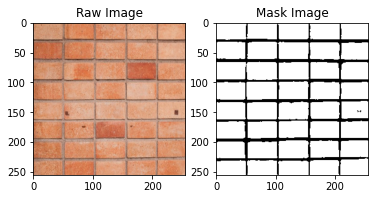

Total Contours Found:  37


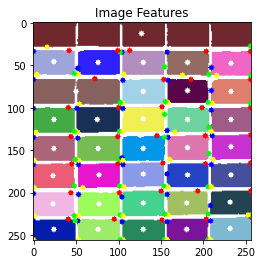

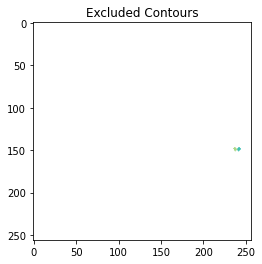

N = Mean contour height /2 : 14.0


area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
34  6725.5  127   13   (127, 13)  ...    NaN   6729.0   1    True
33  1320.0   24   46    (24, 46)  ...    NaN   1320.0   2   False
32  1336.0   76   47    (76, 47)  ...    NaN   1336.0   2   False
31  1321.5  129   47   (129, 47)  ...    NaN   1321.5   2   False
30  1309.5  181   47   (181, 47)  ...    NaN   1309.5   2   False
29  1235.5  232   48   (232, 48)  ...    NaN   1235.5   2   False
28  2772.0   50   81    (50, 81)  ...    NaN   2772.0   3    True
27  1355.0  129   81   (129, 81)  ...    NaN   1355.0   3   False
26  1238.0  181   80   (181, 80)  ...    NaN   1238.0   3   False
25  1262.0  232   81   (232, 81)  ...    NaN   1262.0   3   False
23  1346.0   24  114   (24, 114)  ...    NaN   1346.0   4   False
22  1420.0   75  114   (75, 114)  ...    NaN   1420.0   4   False
24  1349.5  129  113  (129, 113)  ...    NaN   1349.5   4   False
21  1316.0  181  114  (181, 114)  ...    NaN   1316.0   4   False
20  1240.0  232  114  (232, 114)  ...    NaN   1240.0   4   False
16  1339.0   24  148   (24, 148)  ...    NaN   1339.0   5   False
15  1360.5   76  148   (76, 148)  ...    NaN   1360.5   5   False
18  1348.5  129  148  (129, 148)  ...    NaN   1348.5   5   False
17  1293.0  181  147  (181, 147)  ...    NaN   1293.0   5   False
19  1234.5  232  146  (232, 146)  ...    NaN   1234.5   5   False
12  1301.0   23  180   (23, 180)  ...    NaN   1301.0   6   False
11  1288.5   77  179   (77, 179)  ...    NaN   1288.5   6   False
14  1296.5  129  178  (129, 178)  ...    NaN   1296.5   6   False
10  1275.0  181  179  (181, 179)  ...    NaN   1275.0   6   False
13  1230.0  232  179  (232, 179)  ...    NaN   1230.0   6   False
6   1267.5   23  213   (23, 213)  ...    NaN   1267.5   7   False
5   1284.0   77  213   (77, 213)  ...    NaN   1284.0   7   False
9   1383.0  129  212  (129, 212)  ...    NaN   1383.0   7   False
8   1243.5  180  212  (180, 212)  ...    NaN   1243.5   7   False
7   1239.0  231  211  (231, 211)  ...    NaN   1239.0   7   False
3   1122.0   24  243   (24, 243)  ...    NaN   1122.0   8   False
2   1134.5   76  243   (76, 243)  ...    NaN   1134.5   8   False
0   1119.5  129  243  (129, 243)  ...    NaN   1119.5   8   False
1   1130.0  180  243  (180, 243)  ...    NaN   1130.0   8   False
4   1190.0  231  242  (231, 242)  ...    NaN   1190.0   8   False

[35 rows x 14 columns]

area   cX   cY    centroid  ... M[m00] M["m00"] Row outlier
33  1320.0   24   46    (24, 46)  ...    NaN   1320.0   2   False
32  1336.0   76   47    (76, 47)  ...    NaN   1336.0   2   False
31  1321.5  129   47   (129, 47)  ...    NaN   1321.5   2   False
30  1309.5  181   47   (181, 47)  ...    NaN   1309.5   2   False
29  1235.5  232   48   (232, 48)  ...    NaN   1235.5   2   False
27  1355.0  129   81   (129, 81)  ...    NaN   1355.0   3   False
26  1238.0  181   80   (181, 80)  ...    NaN   1238.0   3   False
25  1262.0  232   81   (232, 81)  ...    NaN   1262.0   3   False
23  1346.0   24  114   (24, 114)  ...    NaN   1346.0   4   False
22  1420.0   75  114   (75, 114)  ...    NaN   1420.0   4   False
24  1349.5  129  113  (129, 113)  ...    NaN   1349.5   4   False
21  1316.0  181  114  (181, 114)  ...    NaN   1316.0   4   False
20  1240.0  232  114  (232, 114)  ...    NaN   1240.0   4   False
16  1339.0   24  148   (24, 148)  ...    NaN   1339.0   5   False
15  1360.5   76  148   (76, 148)  ...    NaN   1360.5   5   False
18  1348.5  129  148  (129, 148)  ...    NaN   1348.5   5   False
17  1293.0  181  147  (181, 147)  ...    NaN   1293.0   5   False
19  1234.5  232  146  (232, 146)  ...    NaN   1234.5   5   False
12  1301.0   23  180   (23, 180)  ...    NaN   1301.0   6   False
11  1288.5   77  179   (77, 179)  ...    NaN   1288.5   6   False
14  1296.5  129  178  (129, 178)  ...    NaN   1296.5   6   False
10  1275.0  181  179  (181, 179)  ...    NaN   1275.0   6   False
13  1230.0  232  179  (232, 179)  ...    NaN   1230.0   6   False
6   1267.5   23  213   (23, 213)  ...    NaN   1267.5   7   False
5   1284.0   77  213   (77, 213)  ...    NaN   1284.0   7   False
9   1383.0  129  212  (129, 212)  ...    NaN   1383.0   7   False
8   1243.5  180  212  (180, 212)  ...    NaN   1243.5   7   False
7   1239.0  231  211  (231, 211)  ...    NaN   1239.0   7   False
3   1122.0   24  243   (24, 243)  ...    NaN   1122.0   8   False
2   1134.5   76  243   (76, 243)  ...    NaN   1134.5   8   False
0   1119.5  129  243  (129, 243)  ...    NaN   1119.5   8   False
1   1130.0  180  243  (180, 243)  ...    NaN   1130.0   8   False
4   1190.0  231  242  (231, 242)  ...    NaN   1190.0   8   False

[33 rows x 14 columns]

No. of rows:  7
DF Combined:


cxs_combined  count  ... nogo_percent output
1          [24, 76, 129, 129, 181, 181, 232, 232]    8.0  ...         75.0   True
2          [24, 75, 129, 129, 181, 181, 232, 232]    8.0  ...         75.0   True
3  [24, 24, 75, 76, 129, 129, 181, 181, 232, 232]   10.0  ...        100.0   True
4  [23, 24, 76, 77, 129, 129, 181, 181, 232, 232]   10.0  ...        100.0   True
5  [23, 23, 77, 77, 129, 129, 180, 181, 231, 232]   10.0  ...        100.0   True
6  [23, 24, 76, 77, 129, 129, 180, 180, 231, 231]   10.0  ...        100.0   True

[6 rows x 12 columns]

True
Wall Alignment Check Result:  No Go


Row                       cX  ... count             Mortar Thickness Vertical
0    2  [24, 76, 129, 181, 232]  ...     5     [[4, 6], [2, 0], [3, 17], [3, 8]]
1    3          [129, 181, 232]  ...     3                    [[3, 25], [4, 14]]
2    4  [24, 75, 129, 181, 232]  ...     5  [[3, 27], [4, 27], [3, 19], [3, 20]]
3    5  [24, 76, 129, 181, 232]  ...     5    [[3, 25], [3, 2], [4, 0], [4, 21]]
4    6  [23, 77, 129, 181, 232]  ...     5  [[5, 25], [4, 25], [4, 14], [4, 26]]
5    7  [23, 77, 129, 180, 231]  ...     5  [[5, 25], [2, 21], [3, 23], [3, 10]]
6    8  [24, 76, 129, 180, 231]  ...     5   [[3, 0], [2, 21], [3, 21], [3, 22]]

[7 rows x 10 columns]

In [ ]:
%load_ext google.colab.data_table

def main():
  test_images = sorted([(name,test_image_path+name) for name in os.listdir(test_image_path)])

  for count, file in enumerate(test_images):  #file = (filename, filepath)

    rawimagepath = file [1]
    filename     = file [0]
    print(filename)
    
    ## Get original aspect ratio of raw image
    ar = get_aspect_ratio(rawimagepath) #input = file[1] = filepath

    ## Read and resize image
    raw_image_resized,rgb_image,image_norm = read_image(rawimagepath)  #resized, rgb, and normalised images


    ## Get UNET prediction
    mask,y_pred = get_mask(image_norm)

    ##Display images
    display_two(rgb_image,mask)


    # ## Get key features
    df_features1 = get_key_features(rgb_image,mask)

    # centroids = df_features['centroid'].to_numpy()
    # contour_height = df_features['contour height'].to_numpy()
    # contour_width = df_features['contour height'].to_numpy()
    # display(df_features)
    df_features2 = compute_alignment (df_features1)
    check_mortar_thickness(df_features2)


    
main()